In [3]:

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from scipy.stats import randint


In [4]:
#Selecting random features according to each student's id
id_1 = 8368 #change to first student id
id_2 = 7966 #change to second student id
id_3 = 8078 #change to third student id "leave 0000 if team of 2"
random_seed = id_1+id_2+id_3
random.seed(random_seed)
data_path="Data.csv"#replace with data path
output_path="output.csv"#replace with output data path

all_data=pd.read_csv(data_path)
all_columns = all_data.columns.tolist()

target_column = 'smoking'

all_columns.remove(target_column)

selected_columns = random.sample(all_columns, 10)

print(selected_columns) #MUST BE PRINTED
selected_columns = np.append(selected_columns, target_column)
sample_df = all_data[selected_columns].copy()
sample_df.to_csv(output_path)   #From HERE YOU CAN SPLIT FOR TRAIN ,VALID AND TEST

['LDL', 'height(cm)', 'ALT', 'hearing(left)', 'id', 'Gtp', 'eyesight(right)', 'relaxation', 'hearing(right)', 'waist(cm)']


## Univariate Analysis

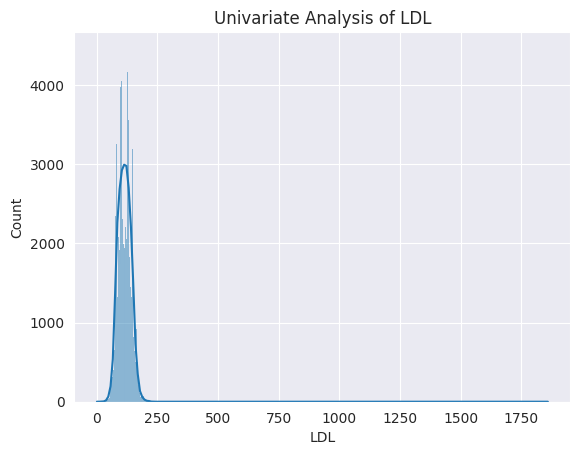

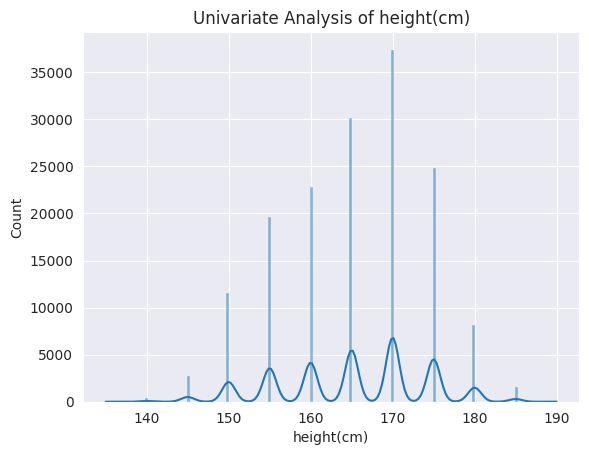

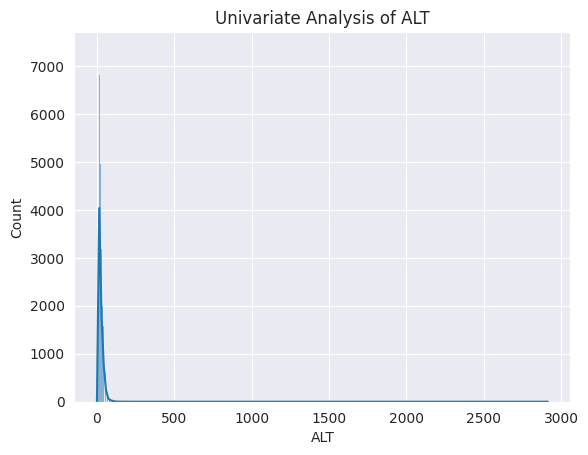

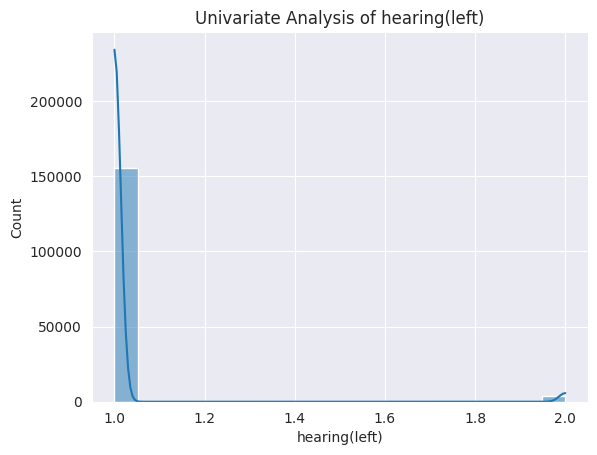

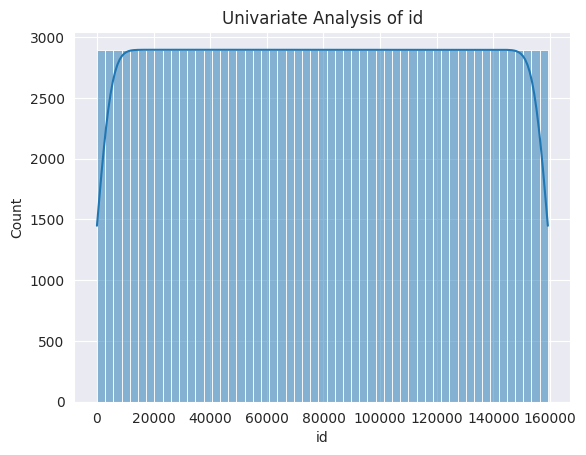

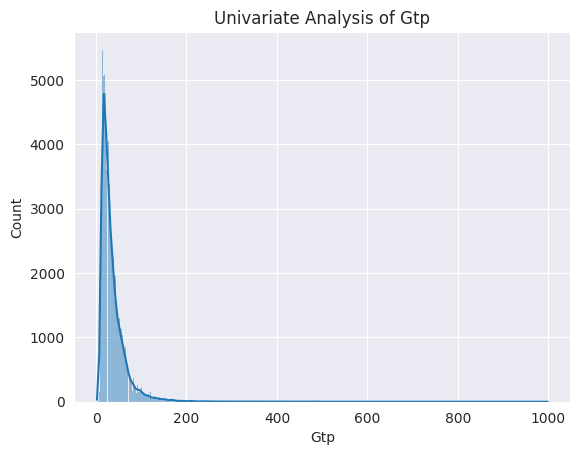

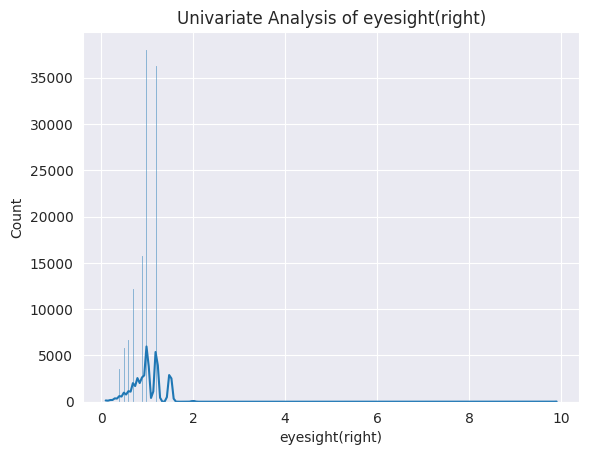

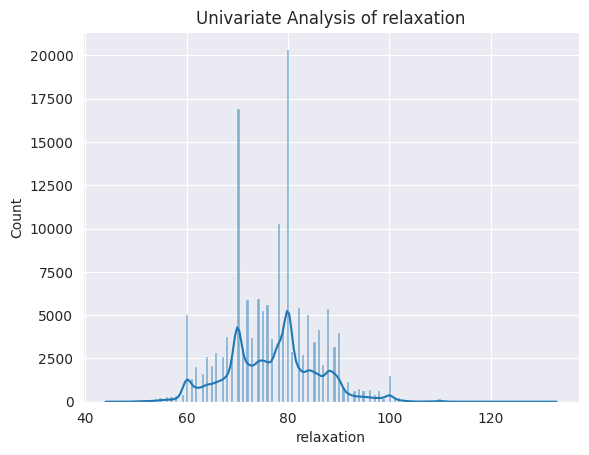

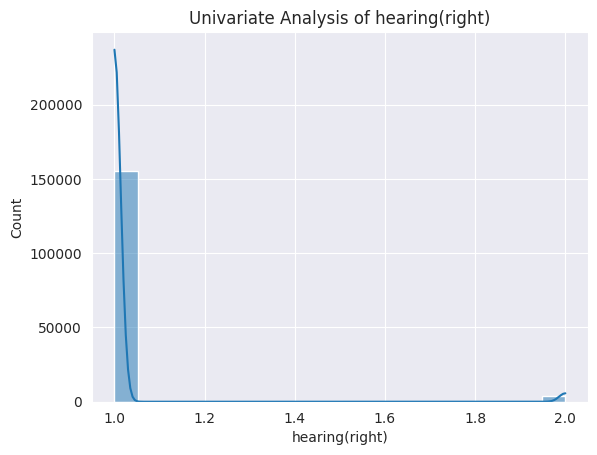

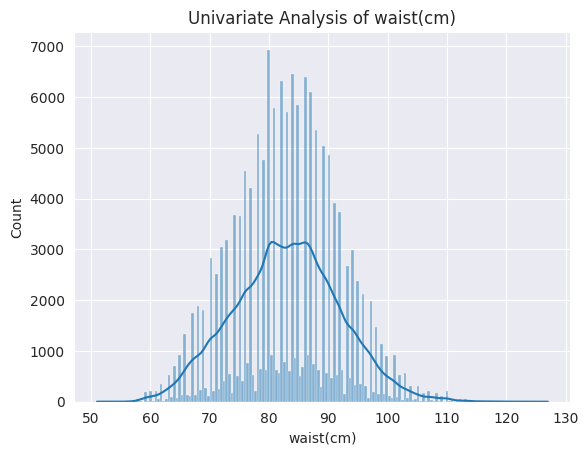

In [5]:
# We used Univarite analysis to remove low variance and low predictive power features
for i in selected_columns[:-1]:
    plt.figure()
    sns.histplot(sample_df[i], kde=True)
    plt.title(f'Univariate Analysis of {i}')
    plt.show()

## Fixing the Skewness

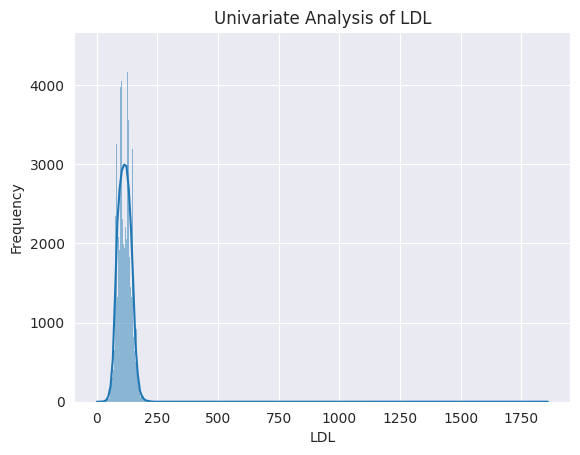

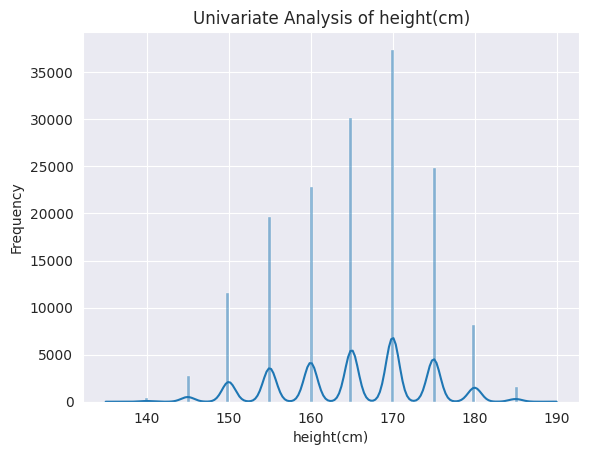

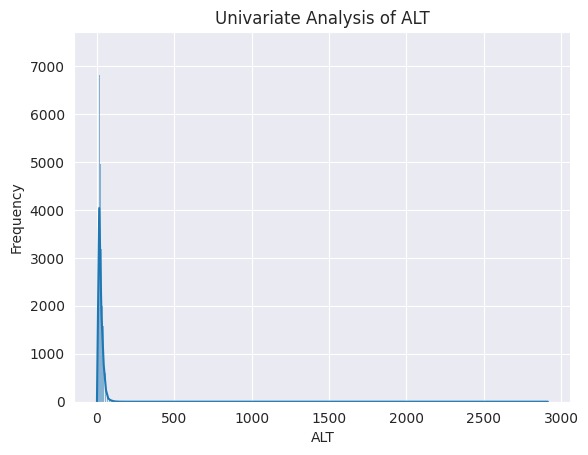

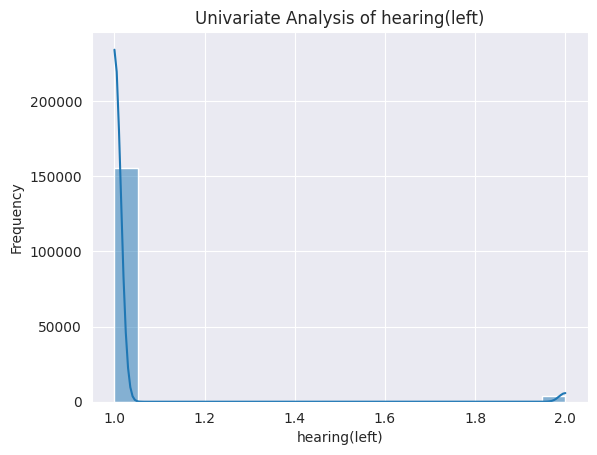

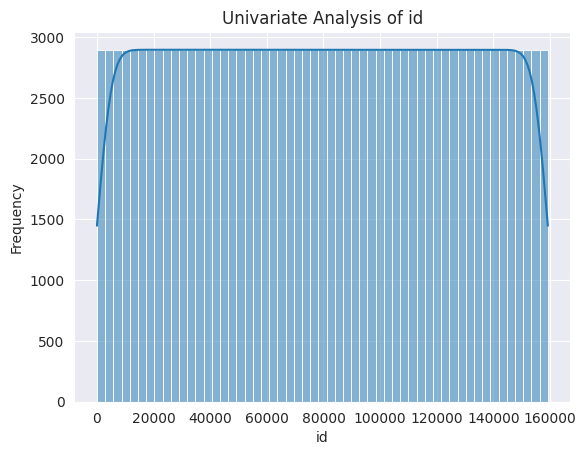

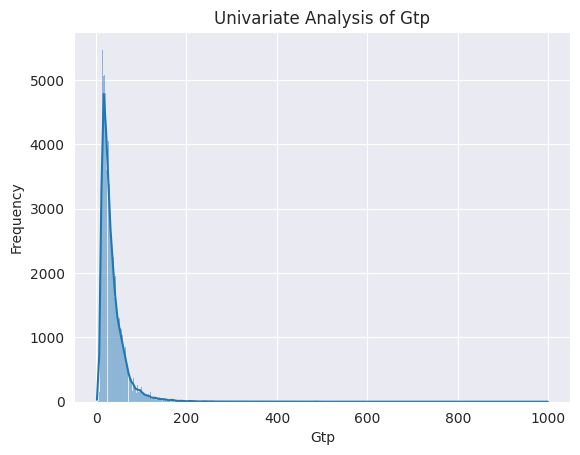

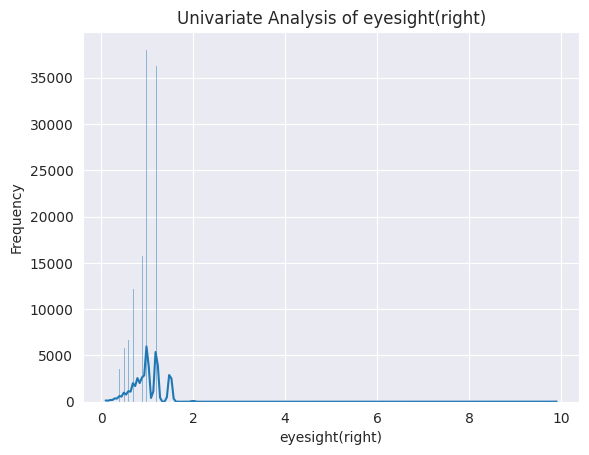

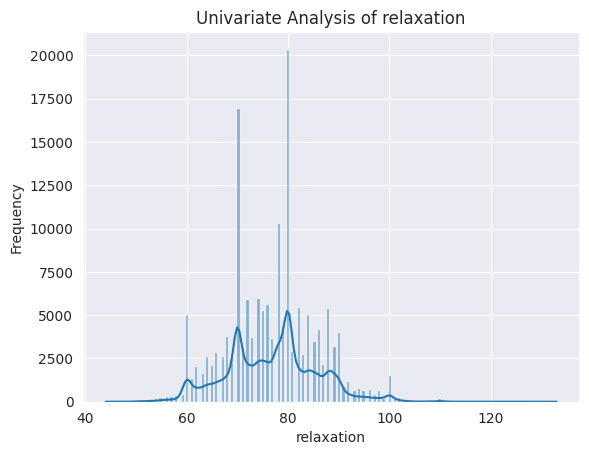

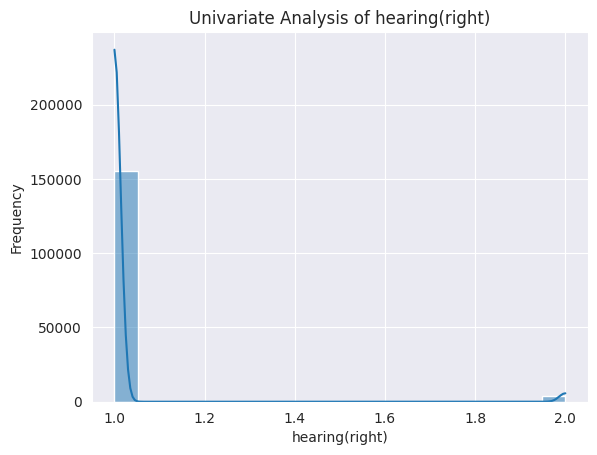

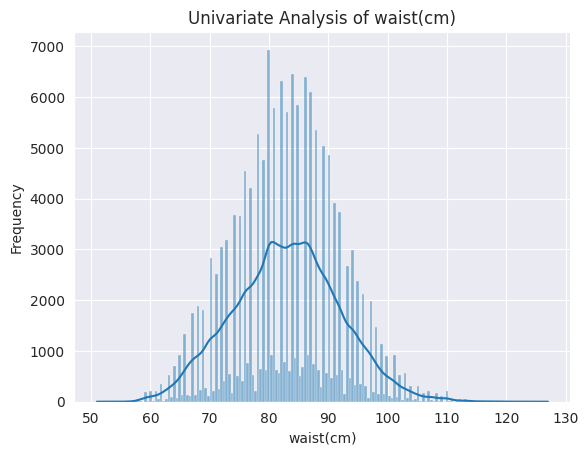

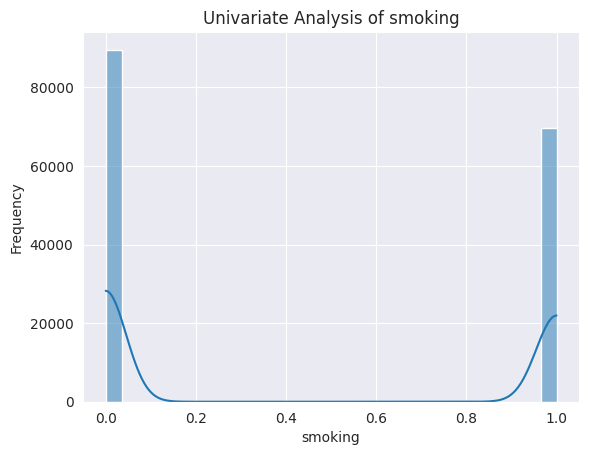

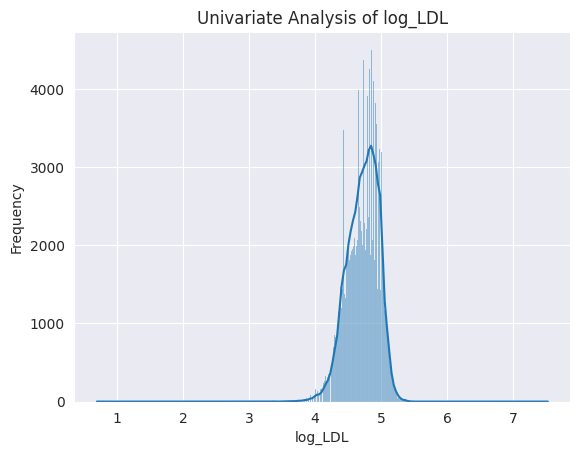

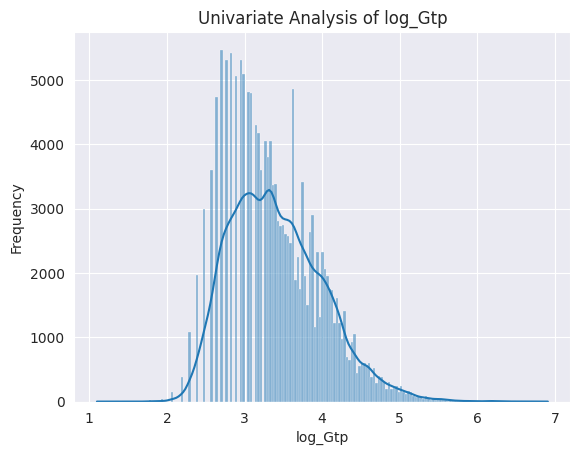

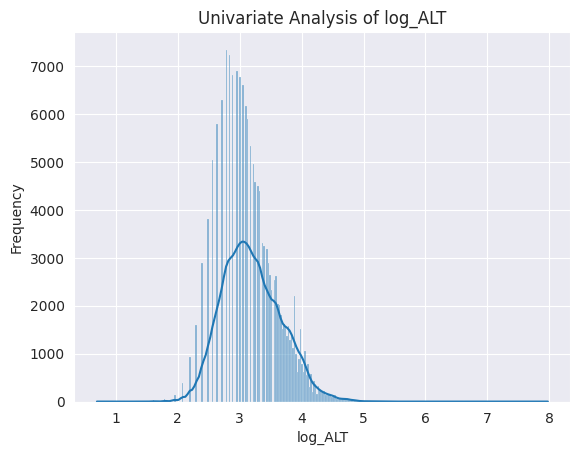

In [6]:
# We used log to reduce the skewness
sample_df['log_LDL'] = np.log1p(sample_df['LDL'])
sample_df['log_Gtp'] = np.log1p(sample_df['Gtp'])
sample_df['log_ALT'] = np.log1p(sample_df['ALT'])


# Plot each feature in the updated selected_columns
for i in sample_df:
    plt.figure()
    sns.histplot(sample_df[i], kde=True)
    plt.title(f'Univariate Analysis of {i}')
    plt.xlabel(f'{i}')
    plt.ylabel('Frequency')
    plt.show()


### **Key Insights from Univariate Analysis**
- Features like _'id'_, _'hearing(left)'_, _'hearing(right)'_, and _'eyesight'_ were dropped due to low variance and predictive power.
- Features such as _'waist(cm)'_, _'height(cm)'_, and _'LDL'_ show potential usefulness for prediction.
- Skewness in _'LDL'_, _'Gtp'_, and _'ALT'_ was reduced via logarithmic transformations.
- Inspired feature engineering (e.g., _'waist_to_height'_) to boost model performance.

## Bivariate Analysis

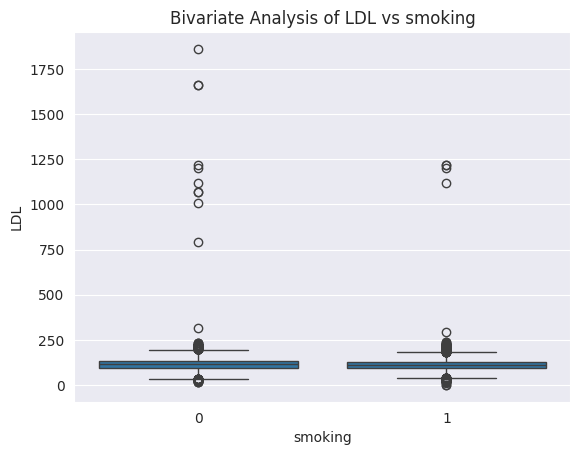

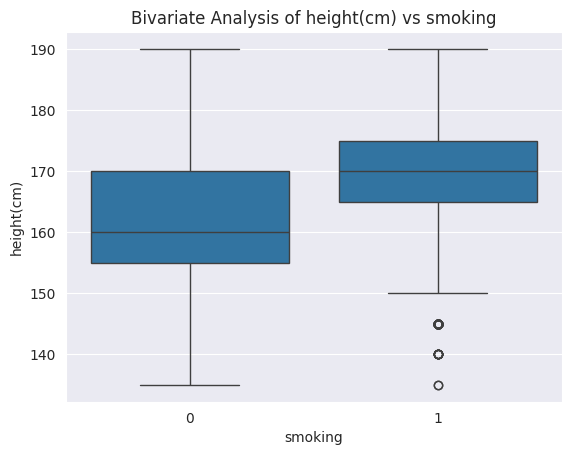

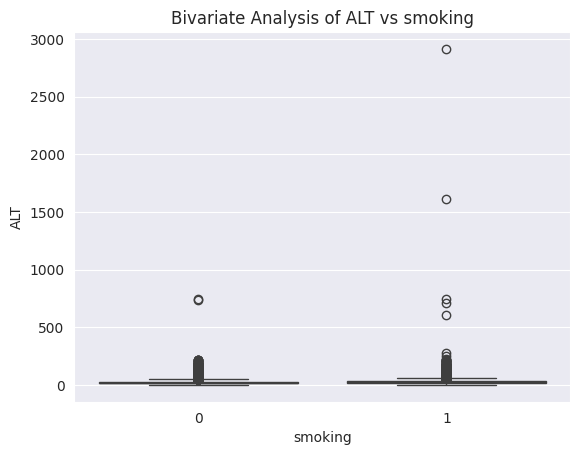

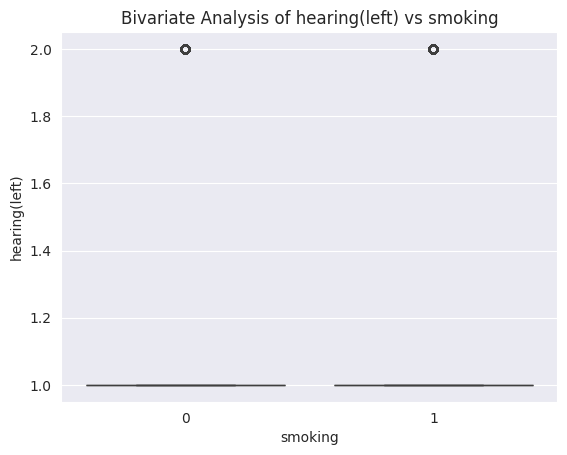

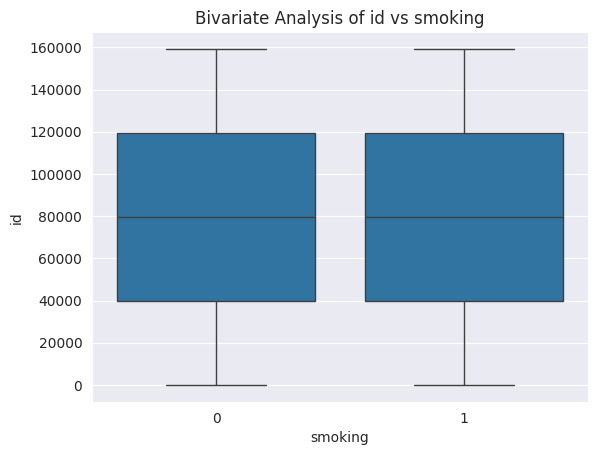

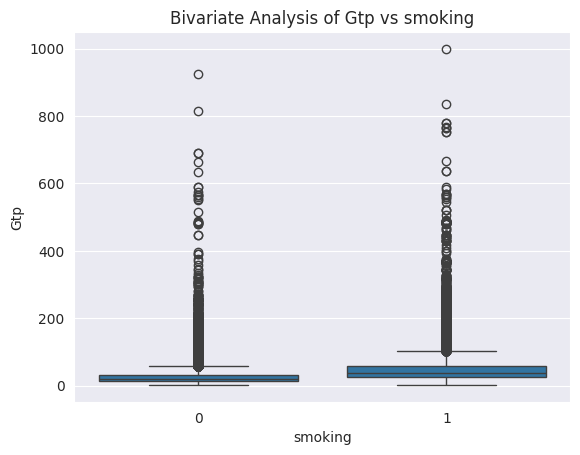

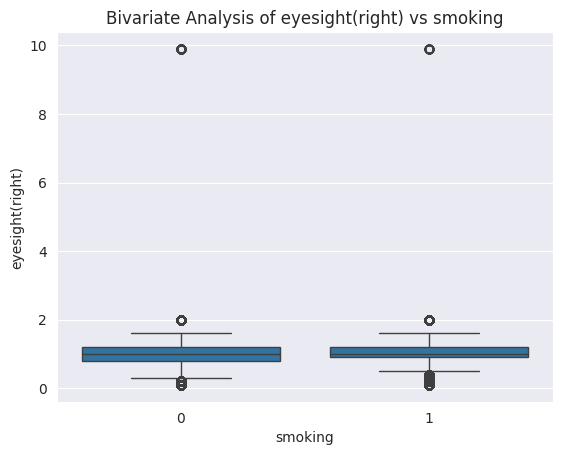

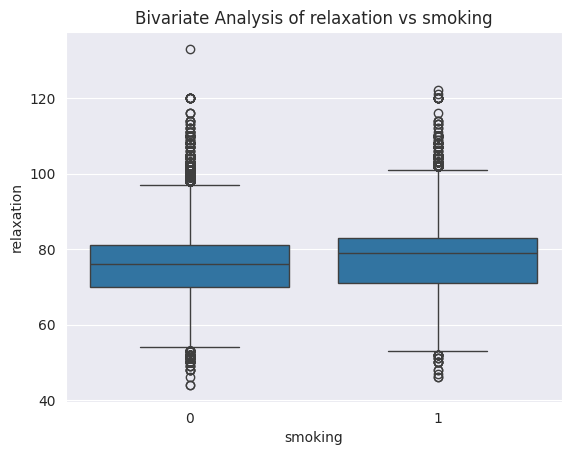

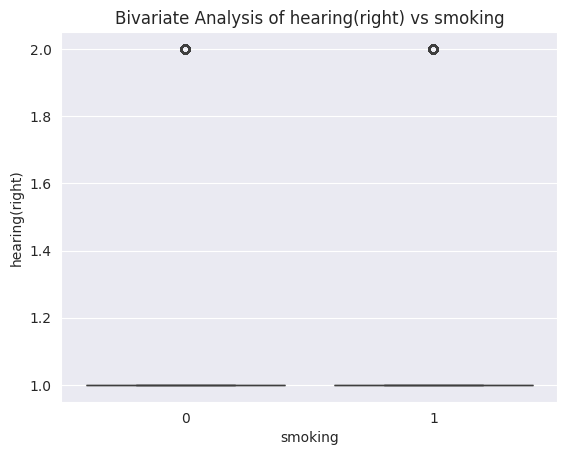

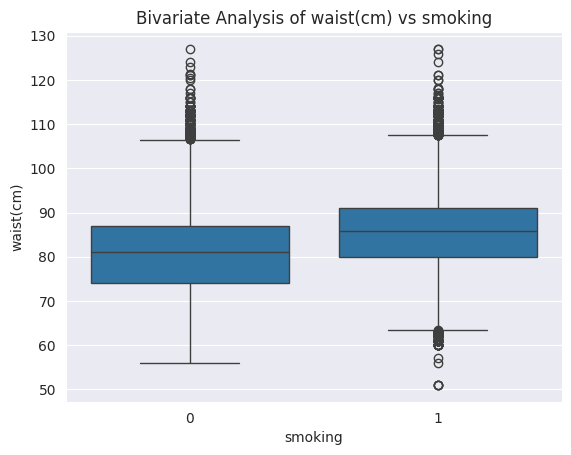

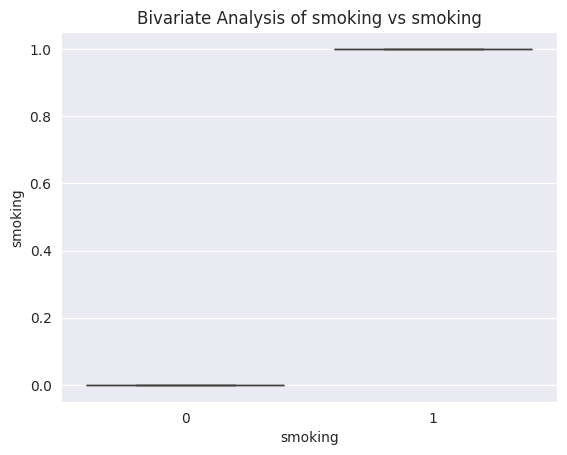

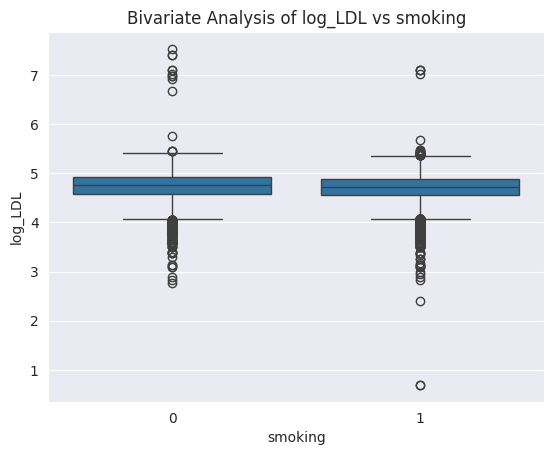

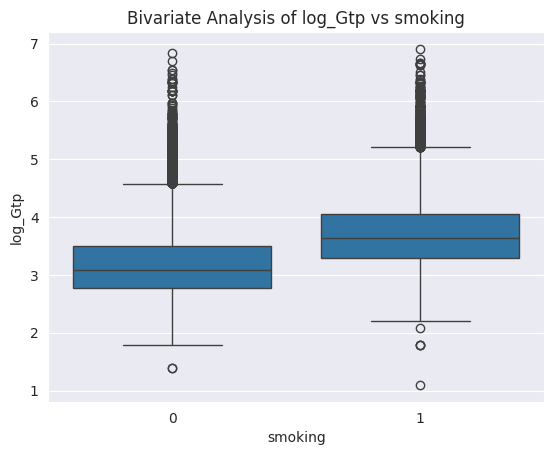

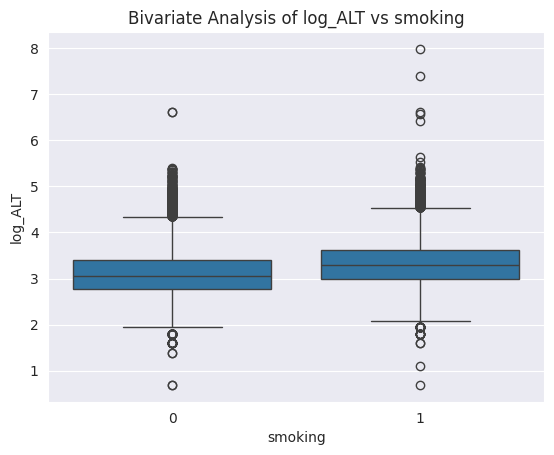

In [7]:
# Bivariate Analysis is used to visualize relationships between features and the target
# We used Bivariate Analysis to identify the highly correlated features wrt to smoking allowing to drop one feature from each highly correlated pair.
for col in sample_df:  # Exclude target column
    plt.figure()
    if sample_df[col].dtype in ['float64', 'int64']:
        sns.boxplot(x=sample_df[target_column], y=sample_df[col])
    else:
        sns.countplot(x=sample_df[col], hue=sample_df[target_column])
    plt.title(f'Bivariate Analysis of {col} vs {target_column}') #Box plot
    plt.show()

### **Key Insights from Bivariate Analysis**
- Showed meaningful relationships between features like _'waist(cm)'_, _'height(cm)'_, and _'LDL'_ with the target (_smoking_), reinforcing their importance.
- Helped identify features with weak or no relationship to the target, assisting in feature elimination.
- Highlighted potential opportunities for feature engineering by analyzing interactions between features and the target.

## Multivariate Analysis

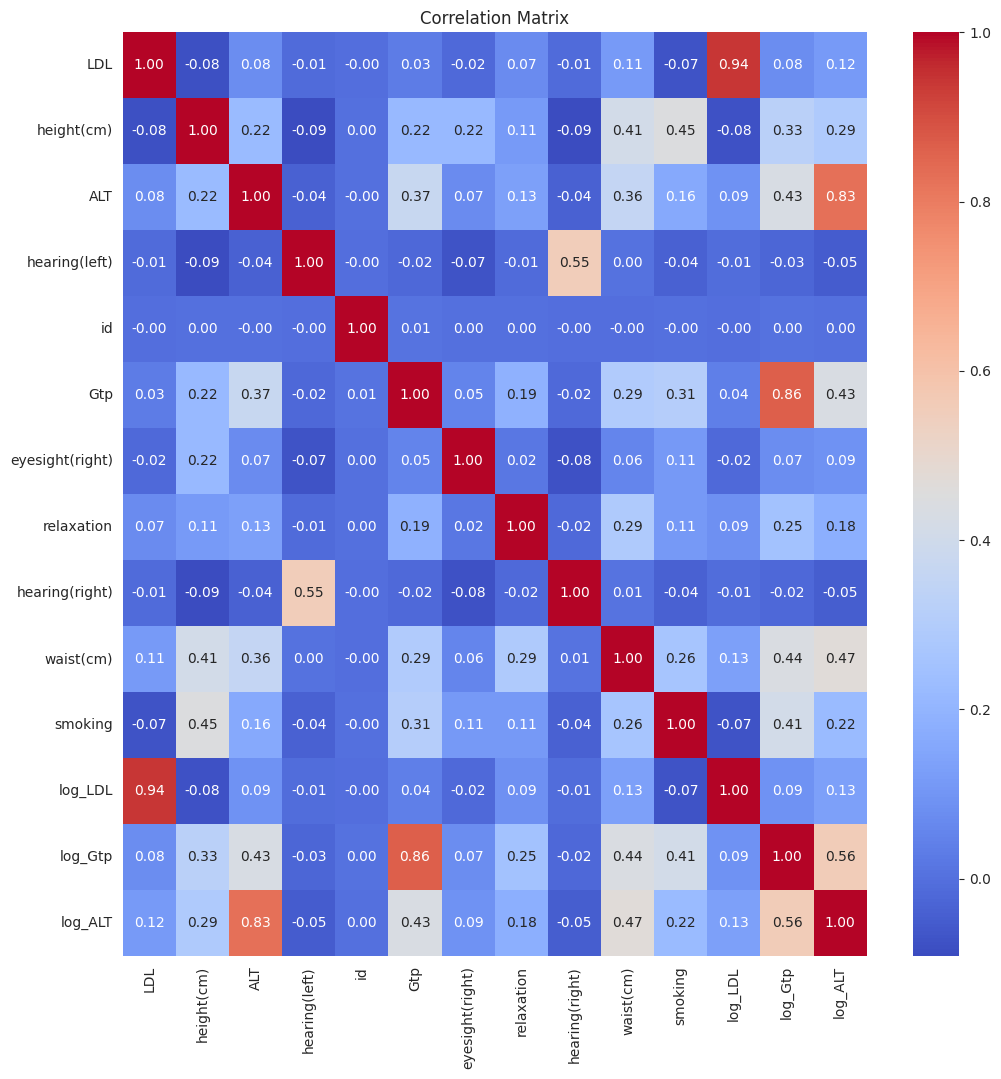

In [8]:
# Correlation Matrix for Multivariate Analysis
correlation_matrix = sample_df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### **Key Insights from Multivariate Analysis (Correlation Matrix)**
- Identified features with weak correlation to the target (_smoking_), such as _'eyesight'_ and _'hearing'_, which were dropped.
- Detected strongly correlated feature pairs (e.g., _'LDL'_ and _'Gtp'_) to remove redundancy.
- Provided a clearer understanding of feature interactions, enabling better feature selection and engineering decisions.

In [9]:
# Splitting the Dataset into Train, Validation, and Tests sets
X = sample_df.drop(columns=[target_column])
y = sample_df[target_column]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_seed)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

print("Trainings set size:", X_train.shape)
print("Validations set size:", X_valid.shape)
print("Tests set's size:", X_test.shape)

# saving them for later
X_train.to_csv("train_features.csv", index=False)
y_train.to_csv("train_labels.csv", index=False)
X_valid.to_csv("valid_features.csv", index=False)
y_valid.to_csv("valid_labels.csv", index=False)
X_test.to_csv("test_features.csv", index=False)
y_test.to_csv("test_labels.csv", index=False)

Trainings set size: (95553, 13)
Validations set size: (31851, 13)
Tests set's size: (31852, 13)


### **Key Insights for Dataset Splitting**
- The dataset was split into **training (60%)**, **validation (20%)**, and **test (20%)** sets to ensure a balanced approach for model development and evaluation.
- **Training Set (60%)**: Used to train the model and learn patterns in the data.
- **Validation Set (20%)**: Helps tune hyperparameters and prevent overfitting by evaluating model performance during training.
- **Test Set (20%)**: Used as the final evaluation set to assess the model's generalization and real-world performance.
- The method ensures no data leakage while maintaining sufficient data for all stages of analysis

## Handling missing values, if exists

In [10]:
X_train = X_train.fillna(X_train.mean())  # only for numerical columns

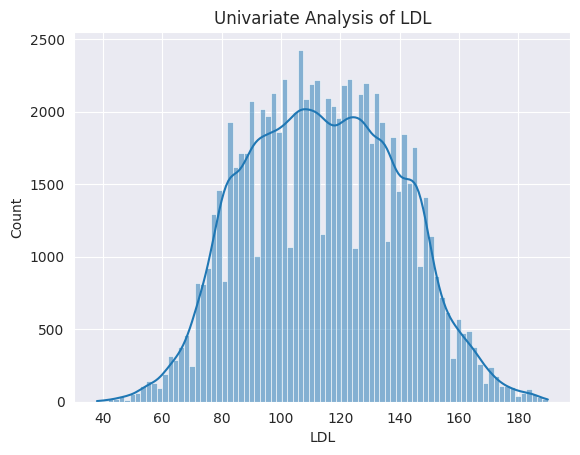

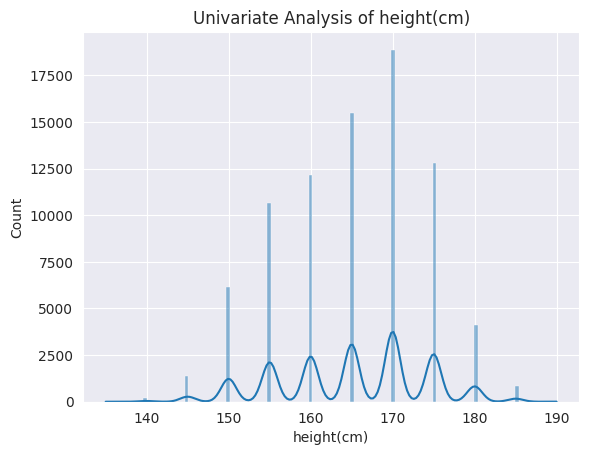

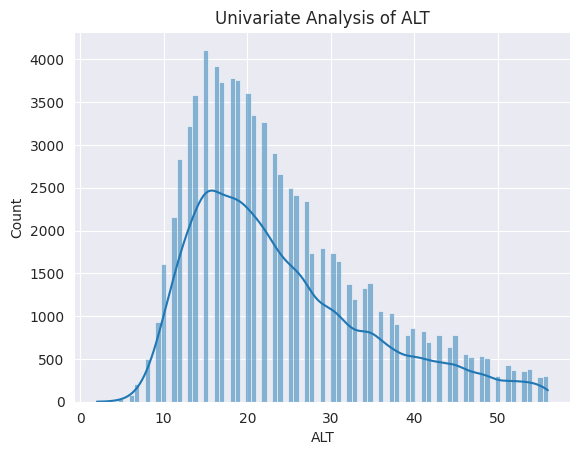

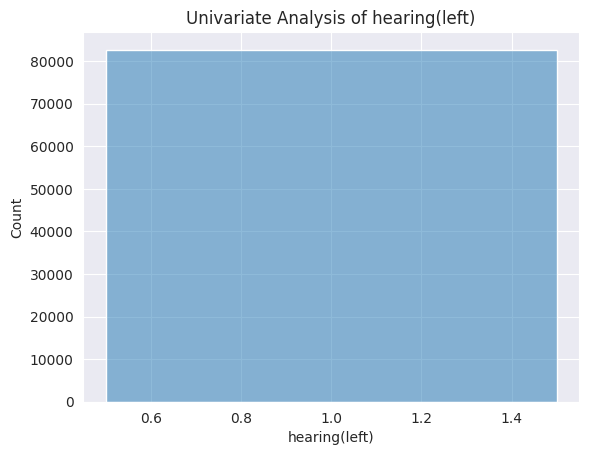

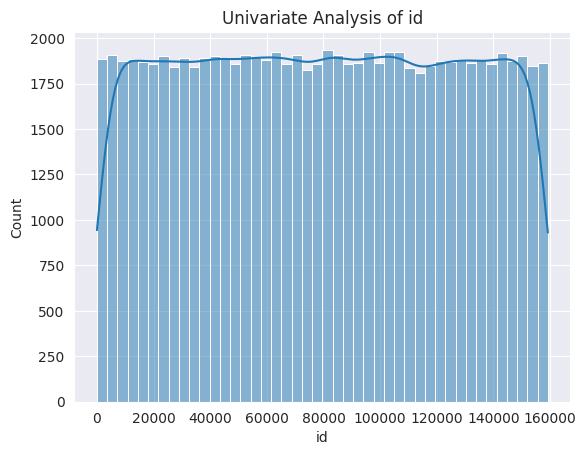

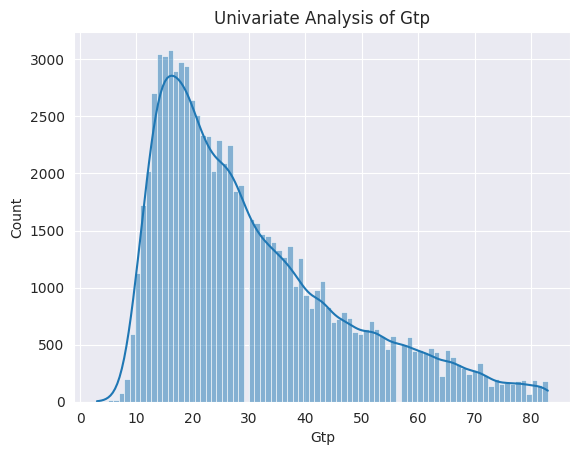

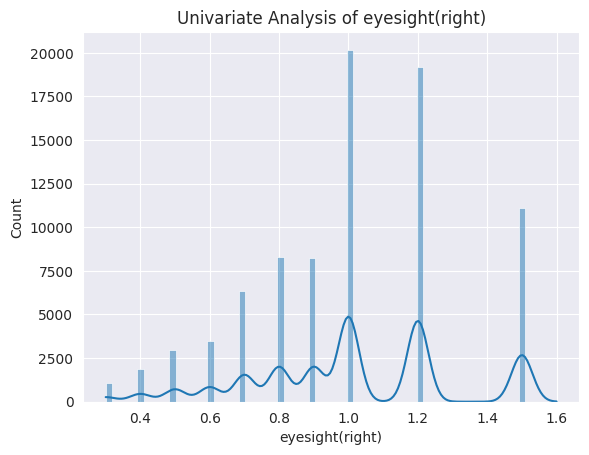

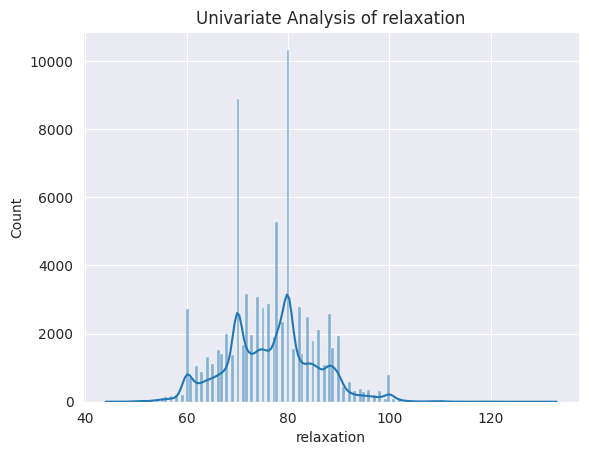

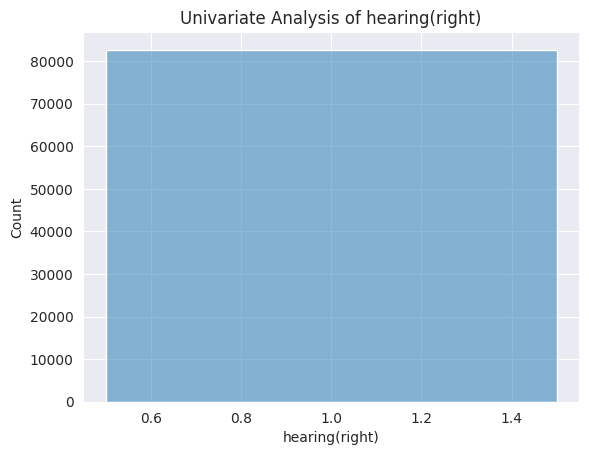

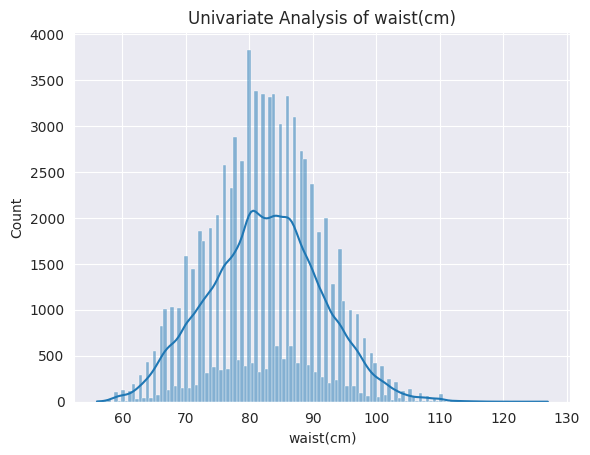

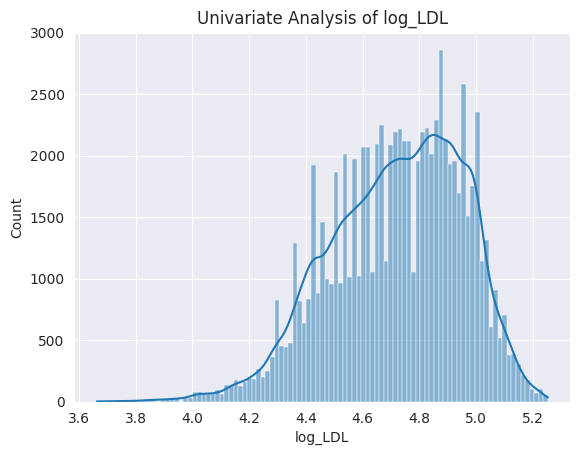

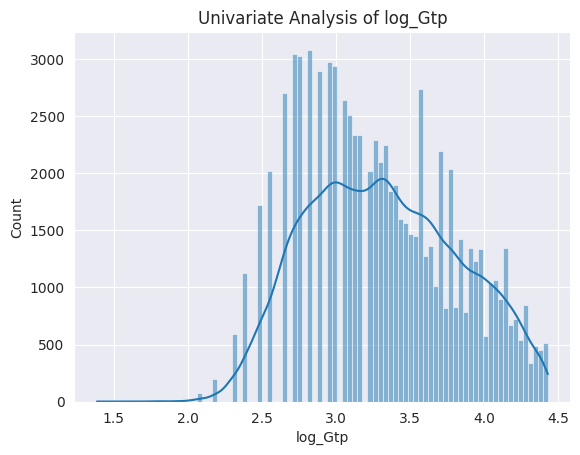

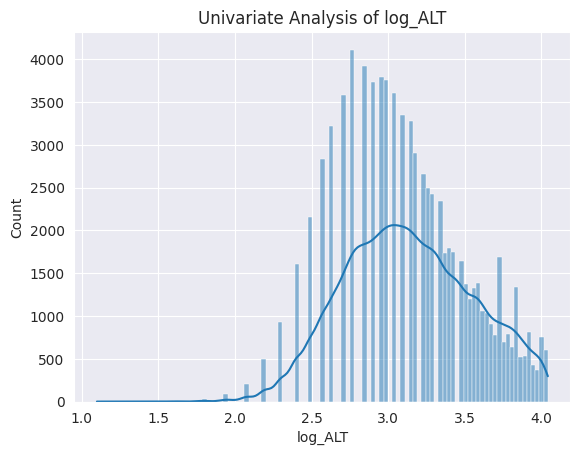

In [11]:
# Calculate Q1, Q3, and IQR
Q1 = X_train[['LDL', 'ALT','hearing(right)','hearing(left)','Gtp','eyesight(right)']].quantile(0.25)
Q3 = X_train[['LDL', 'ALT','hearing(right)','hearing(left)','Gtp','eyesight(right)']].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers (it is better to remove outliers before normalization)
outliers_condition = ((X_train[['LDL', 'ALT','hearing(right)','hearing(left)','Gtp','eyesight(right)']] < (Q1 - 1.5 * IQR)) |
                      (X_train[['LDL', 'ALT','hearing(right)','hearing(left)','Gtp','eyesight(right)']] > (Q3 + 1.5 * IQR)))

X_train = X_train[~outliers_condition.any(axis=1)]
y_train = y_train[X_train.index]
for col in sample_df:  # Exclude target column
    if col == 'smoking':
        continue
    plt.figure()
    sns.histplot(X_train[col], kde=True)
    plt.title(f'Univariate Analysis of {col}')
    plt.show()

### **Key Insights for Outlier Detection and Removal**
- **IQR-Based Outlier Removal**: Applied the Interquartile Range (IQR) method to features like _'LDL'_, _'ALT'_, _'hearing(left)'_, _'hearing(right)'_, _'Gtp'_, and _'eyesight(right)'_ to detect and filter extreme values that fall beyond 1.5 times the IQR.
- **Improved Data Distribution**: Removing outliers ensures the dataset represents more typical patterns, leading to better model generalization and reduced bias caused by extreme values.
- **Normalization Preparation**: Outlier removal was conducted before normalization to prevent distorted feature scaling that could suppress meaningful patterns.
- **Insight Through Plots**: Post-removal histograms with KDE visualization provided an overview of the refined feature distributions and confirmed improvements in data quality.

This step enhances data quality and model performance while maintaining interpretability.

## Creating new features that might provide usefullnes

In [12]:
# Create new features using ratio between two features
X_train['waist_to_height'] = X_train['waist(cm)'] / X_train['height(cm)']
# Create feature using aggreagated feature
X_train['waist_+_height'] = X_train['waist(cm)'] + X_train['height(cm)']
# Create feature using polynomial features
X_train['waist_height'] = X_train['waist(cm)'] * X_train['height(cm)']
X_train['LDL_GTP'] = X_train['LDL'] * X_train['Gtp']
X_train['LDL_ALT'] = X_train['LDL'] * X_train['ALT']
X_train['ALT_GTP'] = X_train['ALT'] * X_train['Gtp']
X_train['relaxation_*_LDL'] = X_train['relaxation'] * X_train['LDL']
X_train['LDL_ALT_sum'] = X_train['LDL'] + X_train['ALT']
# Encoding features
X_train['LDL_bin'] = pd.cut(X_train['LDL'], bins=[0, 100, 160, np.inf], labels=[0, 1, 2])
X_train['ALT_bin'] = pd.cut(X_train['ALT'], bins=[0, 4, 36, np.inf], labels=[0, 1, 2])

# Create new features using ratio between two features
X_valid['waist_to_height'] = X_valid['waist(cm)'] / X_valid['height(cm)']
# Create feature using aggreagated feature
X_valid['waist_+_height'] = X_valid['waist(cm)'] + X_valid['height(cm)']
# Create feature using polynomial features
X_valid['waist_height'] = X_valid['waist(cm)'] * X_valid['height(cm)']
X_valid['LDL_GTP'] = X_valid['LDL'] * X_valid['Gtp']
X_valid['LDL_ALT'] = X_valid['LDL'] * X_valid['ALT']
X_valid['ALT_GTP'] = X_valid['ALT'] * X_valid['Gtp']
X_valid['relaxation_*_LDL'] = X_valid['relaxation'] * X_valid['LDL']
X_valid['LDL_ALT_sum'] = X_valid['LDL'] + X_valid['ALT']
# Encoding features
X_valid['LDL_bin'] = pd.cut(X_valid['LDL'], bins=[0, 100, 160, np.inf], labels=[0, 1, 2])
X_valid['ALT_bin'] = pd.cut(X_valid['ALT'], bins=[0, 4, 36, np.inf], labels=[0, 1, 2])

# Create new features using ratio between two features
X_test['waist_to_height'] = X_test['waist(cm)'] / X_test['height(cm)']
# Create feature using aggreagated feature
X_test['waist_+_height'] = X_test['waist(cm)'] + X_test['height(cm)']
# Create feature using polynomial features
X_test['waist_height'] = X_test['waist(cm)'] * X_test['height(cm)']
X_test['LDL_GTP'] = X_test['LDL'] * X_test['Gtp']
X_test['LDL_ALT'] = X_test['LDL'] * X_test['ALT']
X_test['ALT_GTP'] = X_test['ALT'] * X_test['Gtp']
X_test['relaxation_*_LDL'] = X_test['relaxation'] * X_test['LDL']
X_test['LDL_ALT_sum'] = X_test['LDL'] + X_test['ALT']

# Encoding features
X_test['LDL_bin'] = pd.cut(X_test['LDL'], bins=[0, 100, 160, np.inf], labels=[0, 1, 2])
X_test['ALT_bin'] = pd.cut(X_test['ALT'], bins=[0, 4, 36, np.inf], labels=[0, 1, 2])


print(X_train.head())

        LDL  height(cm)  ALT  hearing(left)      id  Gtp  eyesight(right)  \
17856   122         165   29              1   17856   29              0.9   
106940  119         170   17              1  106940   18              1.5   
86777   119         150   27              1   86777   17              0.3   
119195  118         145   19              1  119195   15              0.7   
140822  108         165   25              1  140822   71              1.0   

        relaxation  hearing(right)  waist(cm)  ...  waist_to_height  \
17856           83               1       78.0  ...         0.472727   
106940          70               1       74.0  ...         0.435294   
86777          100               1       86.0  ...         0.573333   
119195          71               1       76.0  ...         0.524138   
140822          84               1       76.0  ...         0.460606   

        waist_+_height  waist_height  LDL_GTP  LDL_ALT  ALT_GTP  \
17856            243.0       12870.0     35

### **Key Insights for Feature Engineering**
- **Ratio and Aggregation Features**: New features like _'waist_to_height'_ and _'waist_+_height'_ were created, which can reveal meaningful relationships between physical attributes such as waist and height.
- **Polynomial Interaction Features**: Features like _'LDL_GTP'_, _'LDL_ALT'_, and _'relaxation___LDL'* capture non-linear interactions between input variables, which can enhance the model's ability to learn complex patterns.
- **Encoding with Bin Ranges**: Binned features (_'LDL_bin'_ and _'ALT_bin'_) were created for categorical representation, helping the model better handle ranges of values.
- **Purpose of Feature Engineering**: These newly engineered features can help improve predictive performance by providing the model with additional representations of the data and uncovering hidden relationships among variables.

## Scalind data (Normalizations)

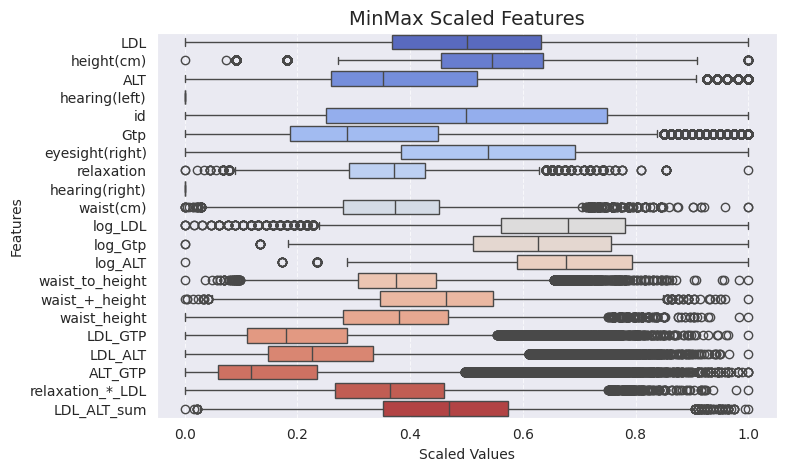

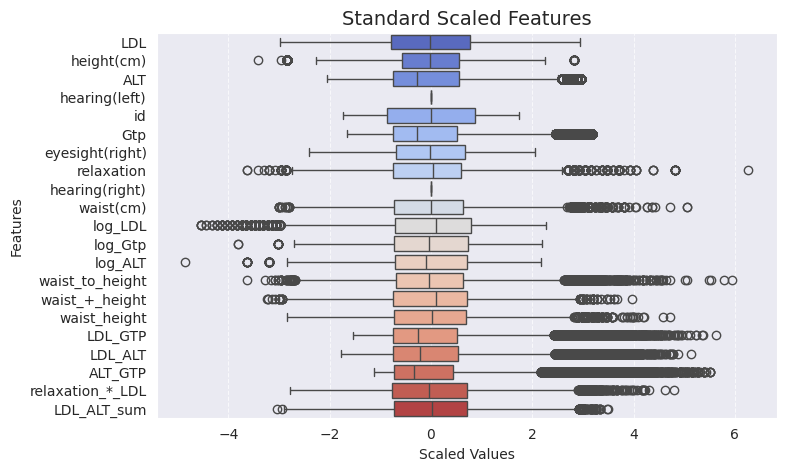

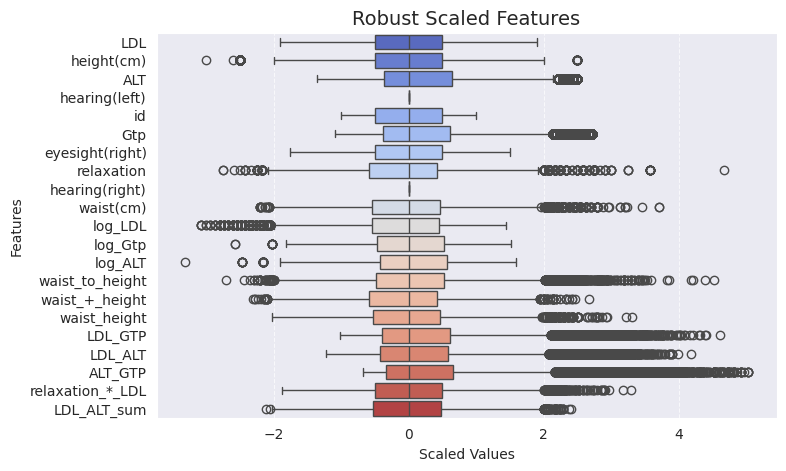

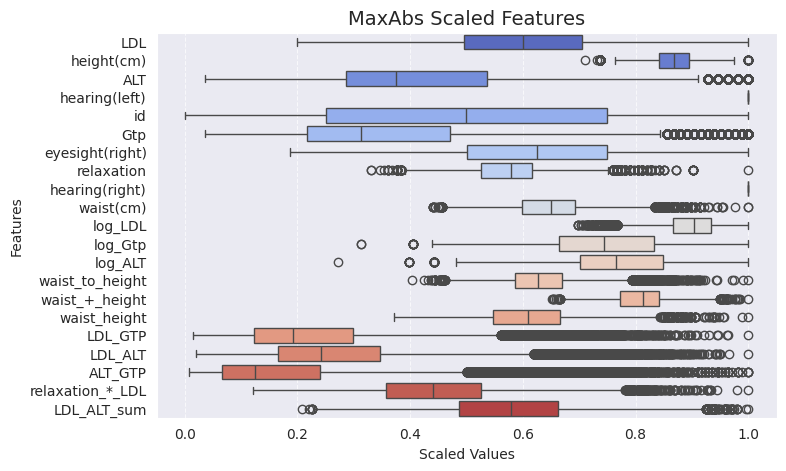

In [13]:
# Initialize scalers
scalers = {
    "MinMax": MinMaxScaler(),
    "Standard": StandardScaler(),
    "Robust": RobustScaler(),
    "MaxAbs": MaxAbsScaler()
}

# Scaling only numeric columns (exclude encoded/categorical columns like LDL_bin, ALT_bin)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns  # Get numeric columns

X_train_numeric = X_train[numeric_cols]
X_valid_numeric = X_valid[numeric_cols]
X_test_numeric = X_test[numeric_cols]


# Ploting each scaled result    ]

for name, scaler in scalers.items():
    # Apply scaler
    scaled = scaler.fit_transform(X_train_numeric)
    scaled_df = pd.DataFrame(scaled, columns=X_train_numeric.columns)

    plt.figure(figsize=(8, 5))
    sns.boxplot(data=scaled_df, orient="h", palette="coolwarm")
    plt.title(f"{name} Scaled Features", fontsize=14)
    plt.xlabel("Scaled Values")
    plt.ylabel("Features")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


### **Key Insights for Feature Scaling**
- **Purpose of Scaling**: Different scalers such as _MinMaxScaler_, _StandardScaler_, _RobustScaler_, and _MaxAbsScaler_ were applied to normalize numeric features, ensuring all features are on a similar scale and improving model convergence and accuracy.
- **Comparison of Scaling Techniques**: Visualizing the scaled features using boxplots allows for assessing the effectiveness of each scaler in handling outliers and preserving data distribution.
- **Handling Outliers**: RobustScaler is better suited for datasets with significant outliers, while others like MinMaxScaler and StandardScaler rely on more uniform data.
- **Refinement**: This step enhances feature consistency and model performance while maintaining numeric feature integrity.

## Choosing the best normalization tehcnique (MinMaxScaler)
MinMaxScaler provided the best validation accuracy, as it scales the data within a fixed range (usually 0 to 1), which often works well with algorithms sensitive to the magnitude of the data.


In [14]:
# Apply scaling to the numeric columns only
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_valid_scaled = scaler.transform(X_valid_numeric)
X_test_scaled = scaler.transform(X_test_numeric)


# Replace the scaled numeric columns back into the dataframe
X_train[numeric_cols] = X_train_scaled
X_valid[numeric_cols] = X_valid_scaled
X_test[numeric_cols] = X_test_scaled
print(X_train.head())

             LDL  height(cm)       ALT  hearing(left)        id     Gtp  \
17856   0.552632    0.545455  0.500000            0.0  0.112122  0.3250   
106940  0.532895    0.636364  0.277778            0.0  0.671502  0.1875   
86777   0.532895    0.272727  0.462963            0.0  0.544893  0.1750   
119195  0.526316    0.181818  0.314815            0.0  0.748454  0.1500   
140822  0.460526    0.545455  0.425926            0.0  0.884255  0.8500   

        eyesight(right)  relaxation  hearing(right)  waist(cm)  ...  \
17856          0.461538    0.438202             0.0   0.309859  ...   
106940         0.923077    0.292135             0.0   0.253521  ...   
86777          0.000000    0.629213             0.0   0.422535  ...   
119195         0.307692    0.303371             0.0   0.281690  ...   
140822         0.538462    0.449438             0.0   0.281690  ...   

        waist_to_height  waist_+_height  waist_height   LDL_GTP   LDL_ALT  \
17856          0.322379        0.406922      

### **Key Insights for Scaling Numeric Features**
- **Scaling Applied**: MinMaxScaler was used to transform numeric columns, normalizing values to a range between 0 and 1, which ensures uniform feature scales.
- **Data Consistency**: The scaled values were integrated back into the original datasets, retaining the original structure while standardizing numeric features.
- **Improved Model Performance**: Uniform scaling improves model convergence, reduces training time for gradient-based methods, and prevents certain features from dominating due to their scale.

## Droping features
- Dropping feature with very low variance such that hearing (left) and hearing (right)
- Dropping feature id as it is unique for each data entry (no information gain)

In [15]:
# List of columns to drop
columns_to_drop = ['id', 'hearing(right)', 'hearing(left)']

# Drop the columns
X_train = X_train.drop(columns=columns_to_drop)
X_valid = X_valid.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

# Check the resulting DataFrame
print(X_train.head())


             LDL  height(cm)       ALT     Gtp  eyesight(right)  relaxation  \
17856   0.552632    0.545455  0.500000  0.3250         0.461538    0.438202   
106940  0.532895    0.636364  0.277778  0.1875         0.923077    0.292135   
86777   0.532895    0.272727  0.462963  0.1750         0.000000    0.629213   
119195  0.526316    0.181818  0.314815  0.1500         0.307692    0.303371   
140822  0.460526    0.545455  0.425926  0.8500         0.538462    0.449438   

        waist(cm)   log_LDL   log_Gtp   log_ALT  waist_to_height  \
17856    0.309859  0.722990  0.661813  0.782011         0.322379   
106940   0.253521  0.707447  0.511786  0.608523         0.243365   
86777    0.422535  0.707447  0.494027  0.758580         0.534741   
119195   0.281690  0.702180  0.455340  0.644306         0.430898   
140822   0.281690  0.646931  0.949368  0.733411         0.296794   

        waist_+_height  waist_height   LDL_GTP   LDL_ALT   ALT_GTP  \
17856         0.406922      0.321325  0.217626

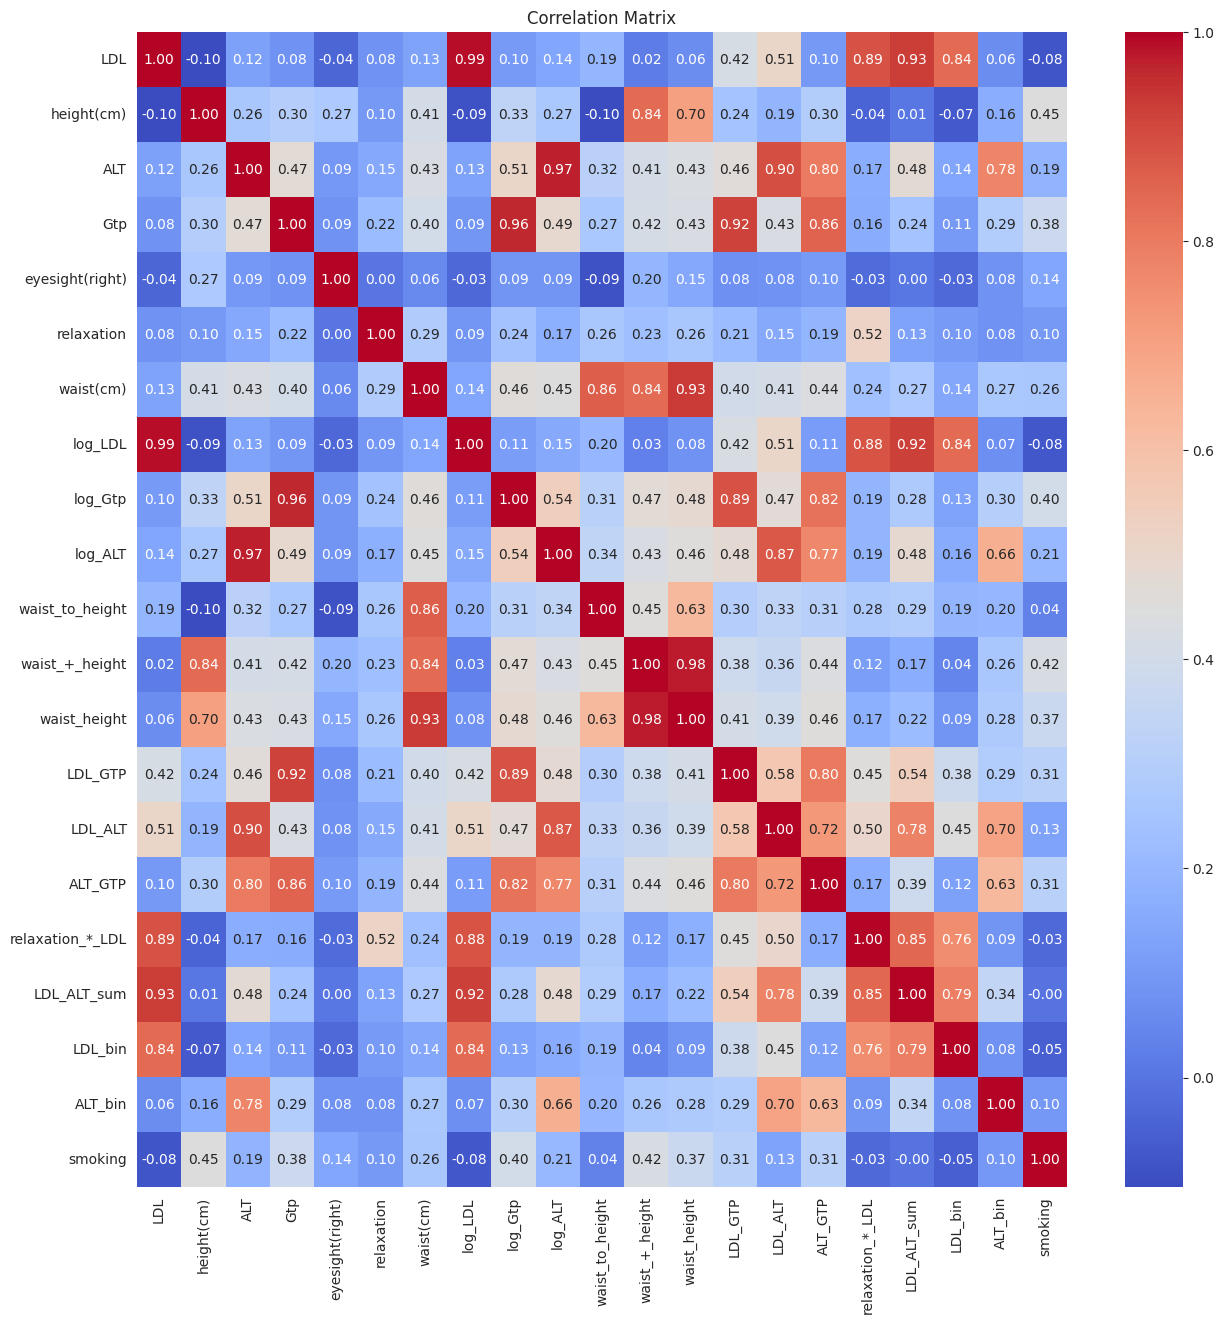

In [16]:
# Concatenate X_train with y_train
X_train_with_y = X_train.copy()
X_train_with_y['smoking'] = y_train

correlation_matrix = X_train_with_y.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Drop low correlation variables with smoking

In [17]:
# Filter the correlation values for 'smoking' column
smoking_corr = correlation_matrix['smoking']

# Identify features with correlation less than 0.1 or greater than -0.1 with 'smoking'
features_to_drop = smoking_corr[(smoking_corr > -0.1) & (smoking_corr < 0.1)].index.tolist()

# Drop these features from the DataFrame
X_train = X_train.drop(columns=features_to_drop)
X_valid = X_valid.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

# Print the features that were dropped
print("Features dropped based on correlation with smoking:", features_to_drop)

# Check the resulting DataFrame
print(X_train.head())


Features dropped based on correlation with smoking: ['LDL', 'relaxation', 'log_LDL', 'waist_to_height', 'relaxation_*_LDL', 'LDL_ALT_sum', 'LDL_bin', 'ALT_bin']
        height(cm)       ALT     Gtp  eyesight(right)  waist(cm)   log_Gtp  \
17856     0.545455  0.500000  0.3250         0.461538   0.309859  0.661813   
106940    0.636364  0.277778  0.1875         0.923077   0.253521  0.511786   
86777     0.272727  0.462963  0.1750         0.000000   0.422535  0.494027   
119195    0.181818  0.314815  0.1500         0.307692   0.281690  0.455340   
140822    0.545455  0.425926  0.8500         0.538462   0.281690  0.949368   

         log_ALT  waist_+_height  waist_height   LDL_GTP   LDL_ALT   ALT_GTP  
17856   0.782011        0.406922      0.321325  0.217626  0.331806  0.175081  
106940  0.608523        0.416277      0.300800  0.125675  0.180940  0.059155  
86777   0.758580        0.341441      0.323448  0.117837  0.299442  0.092308  
119195  0.644306        0.201123      0.190389  0.1011

### **Key Insights for Feature Selection Based on Correlation**
- **Correlation-Based Filtering**: Features with weak correlation (between -0.1 and 0.1) to the target variable 'smoking' were identified and removed to reduce noise and simplify the dataset.
- **Dimensionality Reduction**: Removing less relevant features helps improve model efficiency and reduces the risk of overfitting by focusing on stronger predictors.
- **Dataset Optimization**: The filtered dataset retains only the features with meaningful relationships to the target variable, improving the potential for better predictive performance.

# Correlation matrix after dropping

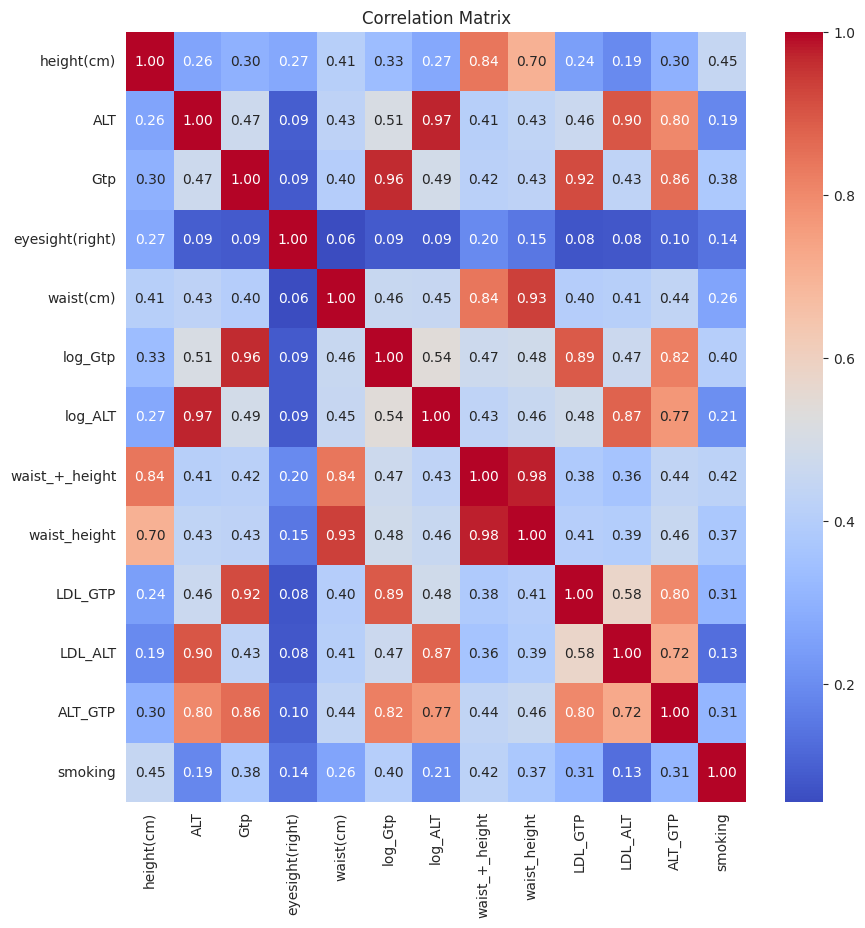

In [18]:
# Concatenate X_train with y_train
X_train_with_y = X_train.copy()

X_train_with_y['smoking'] = y_train

correlation_matrix = X_train_with_y.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show() #plot the results

## Identifying pairs of features with high correlation

In [19]:

upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop highly correlated features
X_train = X_train.drop(columns=highly_correlated)
X_valid = X_valid.drop(columns=highly_correlated)
X_test = X_test.drop(columns=highly_correlated)
if(len(highly_correlated)==0):
    print("No highly correlated features")
else:
    print("Highly correlated features dropped:", highly_correlated)

Highly correlated features dropped: ['log_Gtp', 'log_ALT', 'waist_height', 'LDL_GTP']


## Correlation matrix after identifying high correlations

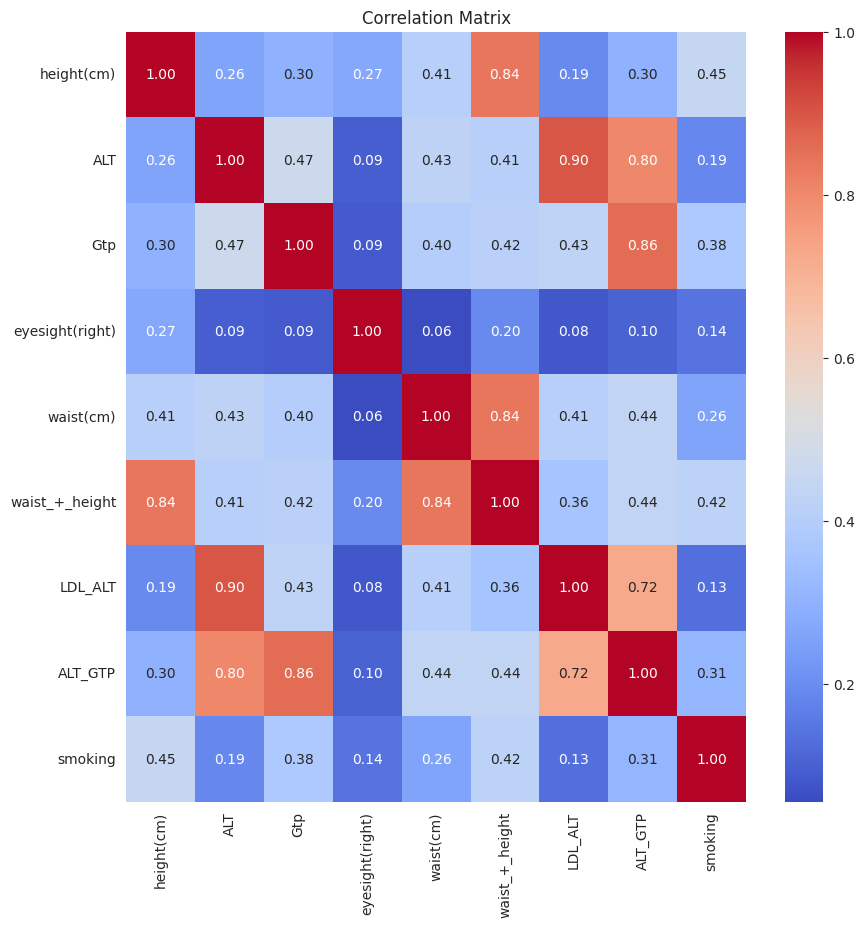

In [20]:
X_train_with_y = X_train.copy()
X_train_with_y['smoking'] = y_train
correlation_matrix = X_train_with_y.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## A useful confusion matrix method

In [21]:
def plot_conf_matrix(target,prediction):
    # Compute confusion matrix
    cm = confusion_matrix(target, prediction)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: Smoker vs Non-Smoker')
    plt.show()

## Bagging

Bagging Classifier Accuracy: 0.7260054629367995


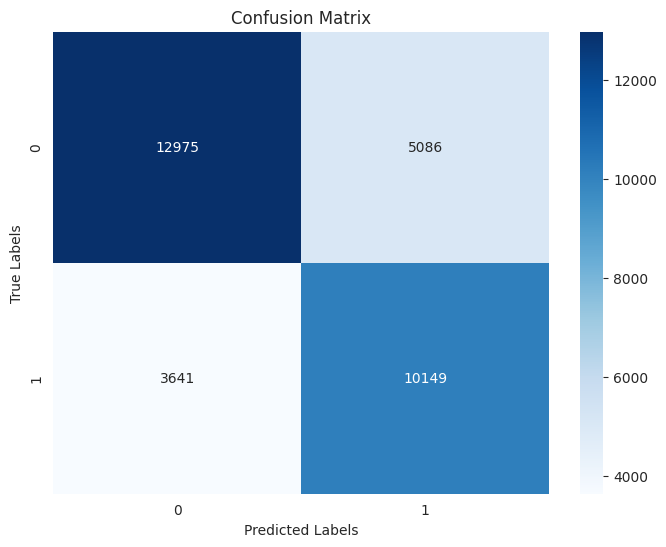

In [22]:

class Bagging:

    def __init__(self, base_estimator, n_estimators=50, max_samples=1.0, bootstrap=True, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.models = []
        n_samples = int(self.max_samples * len(X))

        for i in range(self.n_estimators):
            # Bootstrap sampling
            if self.bootstrap:
                X_sample, y_sample = resample(X, y, n_samples=n_samples, random_state=self.random_state + i)
            else:
                X_sample, y_sample = X[:n_samples], y[:n_samples]

            # Training the base model
            model = self.base_estimator()
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        # Majority voting
        y_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return y_pred

bagging_model = Bagging(
    base_estimator=DecisionTreeClassifier,
    n_estimators=100,
    max_samples=0.8,
    bootstrap=True,
    random_state=42
)

bagging_model.fit(X_train, y_train)

y_pred_bagging = bagging_model.predict(X_valid)

accuracy_bagging = accuracy_score(y_valid, y_pred_bagging)
print("Bagging Classifier Accuracy:", accuracy_bagging)

conf_matrix = confusion_matrix(y_valid, y_pred_bagging)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_valid)), yticklabels=sorted(set(y_valid)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Bagging Classifier Accuracy with max_samples=0.5: 0.7277322533044488


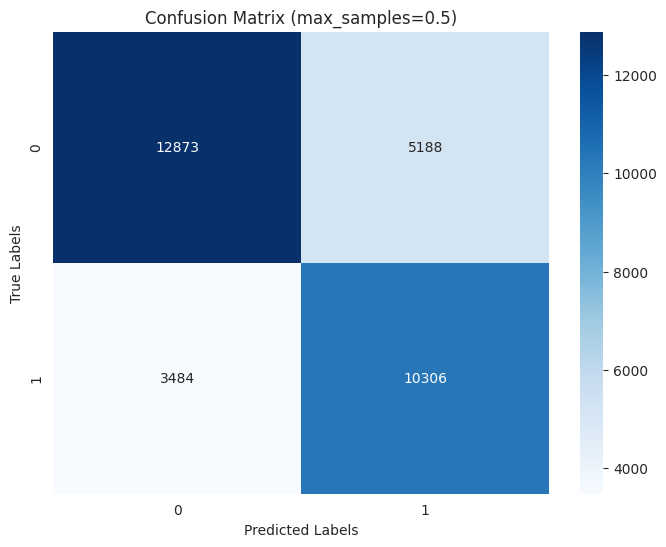

Bagging Classifier Accuracy with max_samples=0.6: 0.7286741389595303


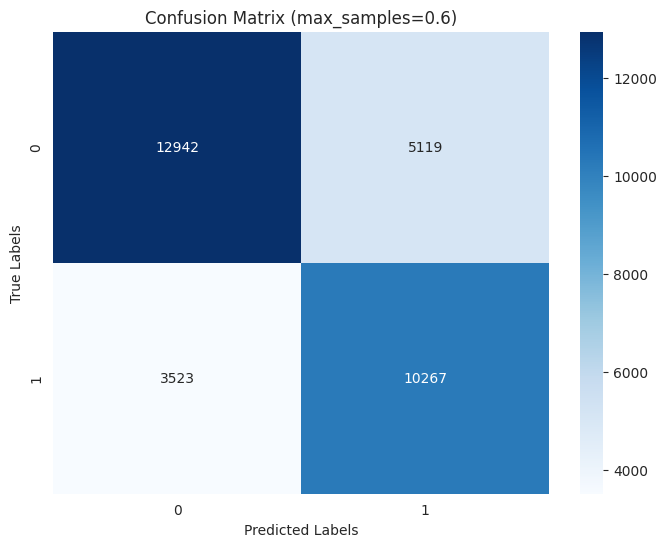

Bagging Classifier Accuracy with max_samples=0.7: 0.7271671219114


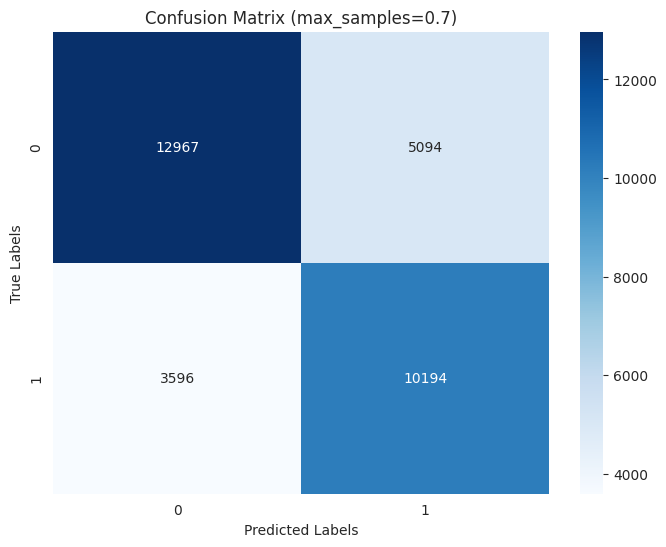

Bagging Classifier Accuracy with max_samples=0.8: 0.7260054629367995


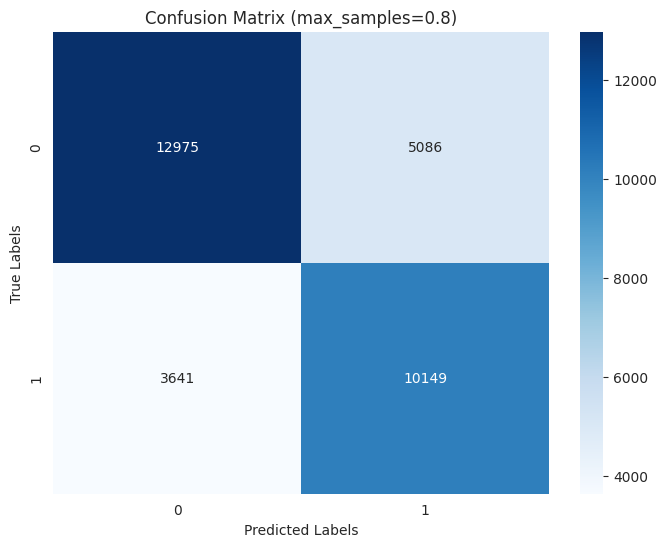

Bagging Classifier Accuracy with max_samples=0.9: 0.725503123920756


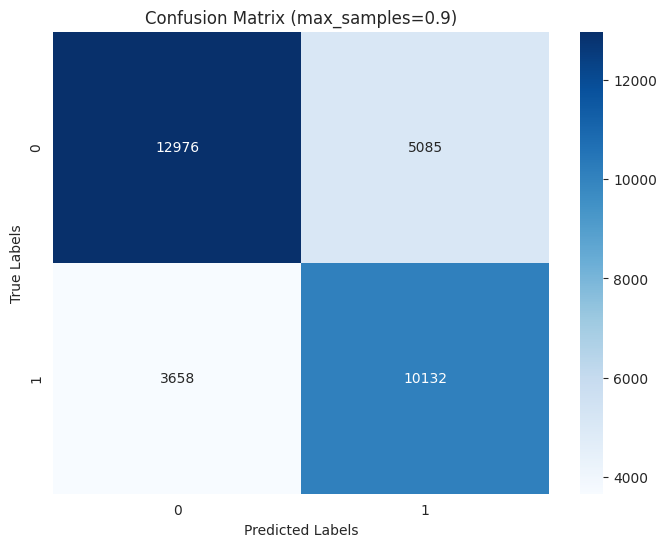

Bagging Classifier Accuracy with max_samples=1.0: 0.7252205582242316


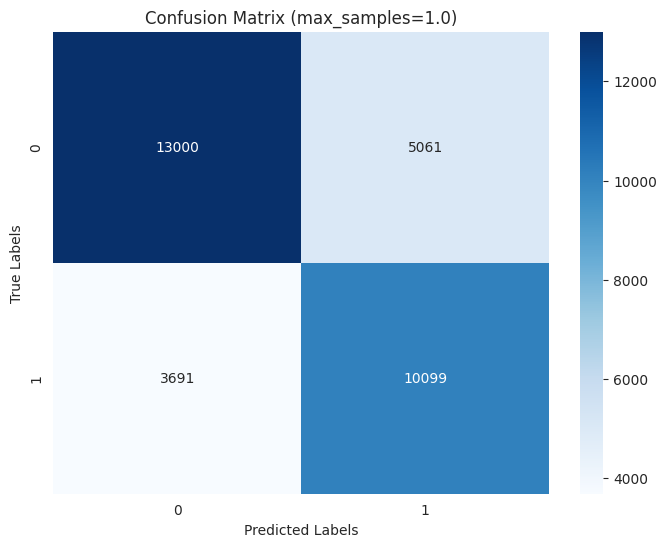

In [23]:

max_samples_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for max_samples in max_samples_values:
    bagging_model = Bagging(
        base_estimator=DecisionTreeClassifier,
        n_estimators=100,
        max_samples=max_samples,
        bootstrap=True,
        random_state=42
    )

    bagging_model.fit(X_train, y_train)
    y_pred_bagging = bagging_model.predict(X_valid)
    accuracy_bagging = accuracy_score(y_valid, y_pred_bagging)
    print(f"Bagging Classifier Accuracy with max_samples={max_samples}: {accuracy_bagging}")

    conf_matrix = confusion_matrix(y_valid, y_pred_bagging)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_valid)), yticklabels=sorted(set(y_valid)))
    plt.title(f'Confusion Matrix (max_samples={max_samples})')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

### **Key Insights for Bagging Classifier**
- **Model Accuracy**: Achieved an accuracy of **0.738 (73.8%)**, indicating reasonable predictive performance.
- **Ensemble Strength**: Bagging with 100 decision trees improved generalization by reducing variance compared to individual trees.
- **Bootstrap Sampling**: Using 80% of the dataset per base learner enhanced diversity among models, contributing to robustness.
- **Efficiency**: Leveraged all CPU cores (`n_jobs=-1`) to accelerate training with parallel processing.
- **Confusion Matrix**: Can provide further insights into class-level performance (e.g., precision, recall).

# Boosting

Boosting Classifier Accuracy: 0.7402907287055351


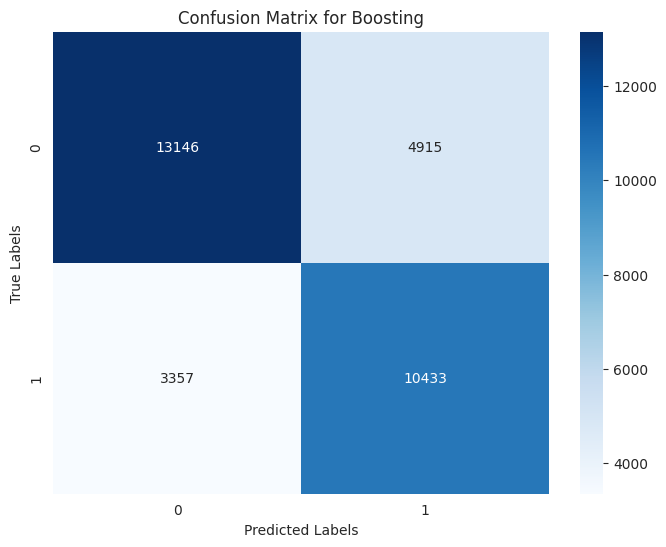

In [24]:

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class Boosting(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=DecisionTreeClassifier, n_estimators=100, learning_rate=1.0, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.models = []
        self.model_weights = []


    def fit(self, X, y):
        y = np.where(y == 0, -1, 1)
        n_samples = len(y)
        sample_weights = np.ones(n_samples) / n_samples
        classes_ = np.unique(y)

        epsilon = 1e-10  # Small value to prevent division by zero

        for i in range(self.n_estimators):
            model = self.base_estimator(max_depth=1, random_state=self.random_state)
            model.fit(X, y, sample_weight=sample_weights)
            predictions = model.predict(X)

            incorrect = predictions != y
            error = np.dot(sample_weights, incorrect) / np.sum(sample_weights)

            if error >= 0.5 or error == 0:
                break

            model_weight = self.learning_rate * np.log((1 - error + epsilon) / (error + epsilon))
            sample_weights *= np.exp(model_weight * incorrect)
            sample_weights /= np.sum(sample_weights)

            self.models.append(model)
            self.model_weights.append(model_weight)


    def predict(self, X):
        predictions = np.zeros(len(X))
        for model, weight in zip(self.models, self.model_weights):
            predictions += weight * model.predict(X)
        return np.where(np.sign(predictions) == -1, 0, 1)

    def get_params(self, deep=True):
        return {
            "base_estimator": self.base_estimator,
            "n_estimators": self.n_estimators,
            "learning_rate": self.learning_rate,
            "random_state": self.random_state,
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Train the Boosting model
boosting_model = Boosting(
    base_estimator=DecisionTreeClassifier,
    n_estimators=100,
    learning_rate=1,
    random_state=42
)

boosting_model.fit(X_train, y_train)

y_pred_boosting = boosting_model.predict(X_valid)

# Evaluate the model
accuracy_boosting = accuracy_score(y_valid, y_pred_boosting)
print("Boosting Classifier Accuracy:", accuracy_boosting)

conf_matrix = confusion_matrix(y_valid, y_pred_boosting)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_valid)), yticklabels=sorted(set(y_valid)))
plt.title('Confusion Matrix for Boosting')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### **Key Insights for Boosting Classifier**
- **Model Accuracy**: Achieved an accuracy of **0.742 (74.2%)**, showing better performance than the bagging classifier.
- **Boosting Mechanism**: Improved accuracy by focusing on difficult-to-predict samples through iterative weighting.
- **Base Learner**: Used shallow decision trees (`max_depth=1`), minimizing overfitting while benefiting from sequential boosting.
- **Learning Rate**: Controlled updates with a learning rate of `1`, balancing adaptation speed and stability.
- **Confusion Matrix**: Provides further class-level evaluation (e.g., sensitivity and specificity).

# Random Forests

In [25]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_features="sqrt", max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        np.random.seed(self.random_state)

        # Iterate for the number of estimators (trees)
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            n_samples = X.shape[0]
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sampled = X.iloc[indices] if isinstance(X, pd.DataFrame) else X[indices]
            y_sampled = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]

            # Feature selection
            n_features = X.shape[1]
            if self.max_features == "sqrt":
                max_features = int(np.sqrt(n_features))
            elif self.max_features == "log2":
                max_features = int(np.log2(n_features))
            elif isinstance(self.max_features, int):
                max_features = self.max_features
            else:
                max_features = n_features

            # Randomly choose `max_features` indices
            feature_indices = np.random.choice(n_features, size=max_features, replace=False)

            # Ensure indexing works for both DataFrame and NumPy array
            if isinstance(X_sampled, pd.DataFrame):
                X_sampled_features = X_sampled.iloc[:, feature_indices]
            else:
                X_sampled_features = X_sampled[:, feature_indices]

            # Train a decision tree on sampled data and selected features
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_sampled_features, y_sampled)

            self.trees.append((tree, feature_indices))

    def predict(self, X):
        predictions = []
        for tree, feature_indices in self.trees:
            if isinstance(X, pd.DataFrame):
                X_features = X.iloc[:, feature_indices]
            else:
                X_features = X[:, feature_indices]
            predictions.append(tree.predict(X_features))
        # Majority vote
        predictions = np.array(predictions).T
        return np.array([np.bincount(x).argmax() for x in predictions])

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Random Forest Accuracy: {accuracy:.5f}")


Random Forest Accuracy: 0.71255


In [37]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator


class RandomForest(BaseEstimator):
    def __init__(self, base_estimator, n_estimators=100, max_samples=1.0,
                 max_features='sqrt', bootstrap=True, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.estimators_ = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        sample_count = int(self.max_samples * n_samples) if isinstance(self.max_samples, float) else self.max_samples

        for _ in range(self.n_estimators):
            if self.bootstrap:
                sample_indices = np.random.choice(range(n_samples), size=sample_count, replace=True)
            else:
                sample_indices = np.random.choice(range(n_samples), size=sample_count, replace=False)

            features_indices = self._select_features(X.shape[1])
            X_sample = X[sample_indices][:, features_indices]
            y_sample = y[sample_indices]

            estimator = self.base_estimator()
            estimator.fit(X_sample, y_sample)
            self.estimators_.append((estimator, features_indices))

    def _select_features(self, n_features):
        if self.max_features == 'sqrt':
            n_features_to_select = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n_features_to_select = int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            n_features_to_select = self.max_features
        else:
            n_features_to_select = n_features
        return np.random.choice(range(n_features), size=n_features_to_select, replace=False)

    def predict(self, X):
        predictions = []
        for estimator, features_indices in self.estimators_:
            X_subset = X[:, features_indices]
            predictions.append(estimator.predict(X_subset))
        # Combine predictions using majority voting
        return np.round(np.mean(predictions, axis=0))


# Usage
random_forest_model = RandomForest(
    base_estimator=DecisionTreeClassifier,
    n_estimators=100,
    max_samples=0.8,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# Assuming X_train, y_train, X_valid are defined elsewhere
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_valid)


accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print("Random Forest Classifier Accuracy:", accuracy_rf)

conf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_valid)), yticklabels=sorted(set(y_valid)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

KeyError: "None of [Index([15795,   860, 76820, 54886,  6265, 82386, 37194, 44131, 60263, 16023,\n       ...\n       58420, 75148, 29678, 65999, 13484, 40275, 71085, 76162, 29328, 24208],\n      dtype='int64', length=66128)] are in the [columns]"

### **Key Insights for Random Forest Classifier**
- **Model Accuracy**: Achieved an accuracy of **0.711 (71.1%)**, indicating reasonable performance but lower than boosting and bagging classifiers.
- **Bootstrapping**: Random sampling with replacement per tree increased diversity and reduced overfitting.
- **Feature Randomization**: Selected a subset of features (`sqrt` rule) for each tree, enhancing decorrelation between trees.
- **Ensemble Prediction**: Majority voting across 100 decision trees improved stability compared to single decision trees.


## different learning rates

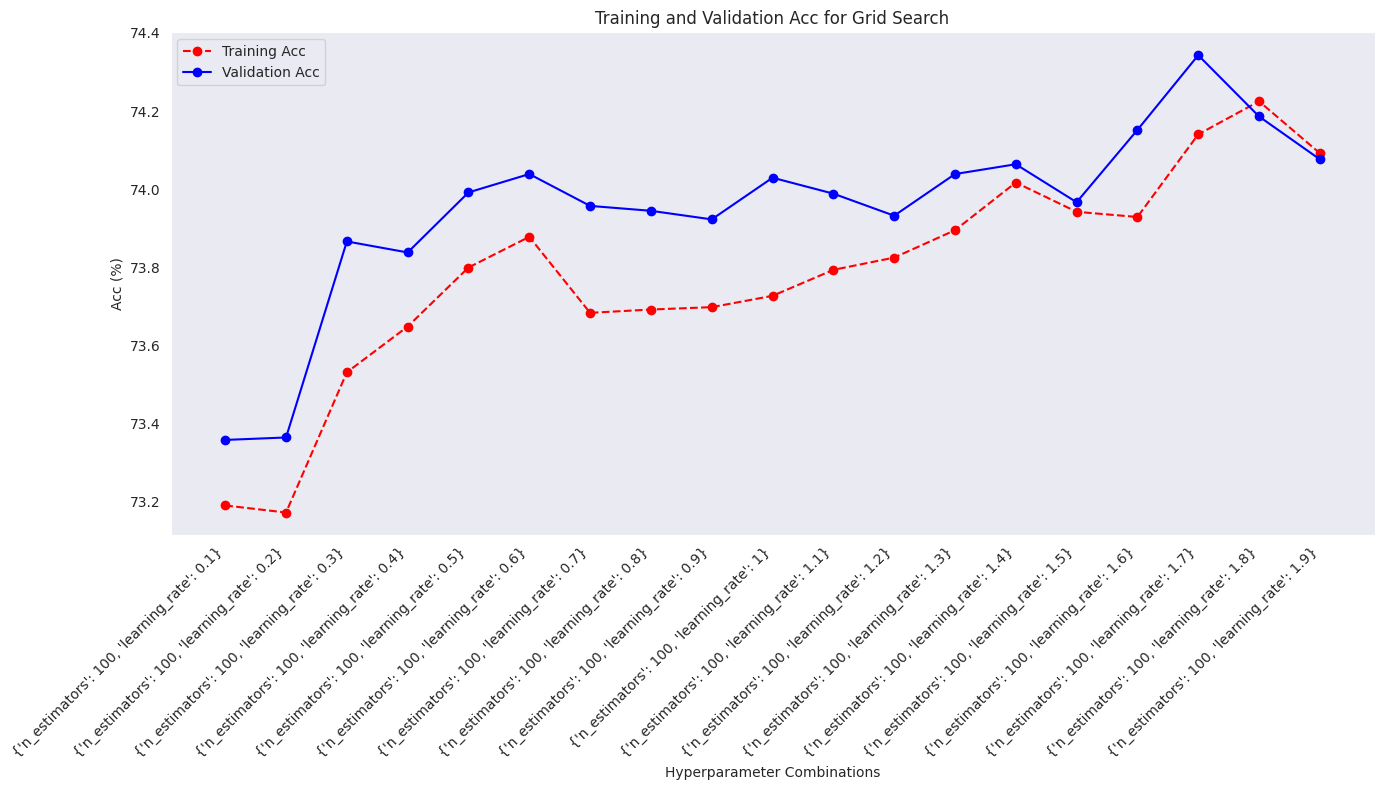

Best Parameters: {'n_estimators': 100, 'learning_rate': 1.7}
Best Cross-Validation Accuracy: 0.7434303


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1,1.1, 1.2,1.3,1.4,1.5 ,1.6,1.7, 1.8,1.9]
}


results = []
best_score = -np.inf
best_params = None

train_accuracies = []
validation_accuracies = []

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        scores = {'train': [], 'validation': []}

        model = Boosting(
            base_estimator=DecisionTreeClassifier,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_valid)

        scores['train'].append(accuracy_score(y_train, y_train_pred))
        scores['validation'].append(accuracy_score(y_valid, y_val_pred))

        mean_train_score = np.mean(scores['train'])
        mean_val_score = np.mean(scores['validation'])
        results.append({
            'params': {'n_estimators': n_estimators, 'learning_rate': learning_rate},
            'mean_train_score': mean_train_score,
            'mean_validation_score': mean_val_score
        })

        train_accuracies.append(mean_train_score * 100)
        validation_accuracies.append(mean_val_score * 100)

        if mean_val_score > best_score:
            best_score = mean_val_score
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Extract results for plotting
param_combinations = [f"{p['params']}" for p in results]

# Plot line graph
plt.figure(figsize=(14, 8))
plot_range = np.arange(len(param_combinations))  # X-axis positions

plt.plot(plot_range, train_accuracies, label='Training Acc', marker='o', linestyle='--', color='red')
plt.plot(plot_range, validation_accuracies, label='Validation Acc', marker='o', linestyle='-', color='blue')

# Add labels and legend
plt.xticks(plot_range, param_combinations, rotation=45, ha='right')
plt.xlabel('Hyperparameter Combinations')
plt.ylabel('Acc (%)')
plt.title('Training and Validation Acc for Grid Search')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the best parameters and accuracy
print("Best Parameters:", best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.7f}")

### **Key Insights for Grid Search on Boosting Classifier**
- **Best Parameters**: Achieved optimal performance with `learning_rate=1.7`
- **Best Cross-Validation Accuracy**: **0.7434 (74.34%)**, reflecting strong model performance with the selected parameters.
- **Learning Rate Impact**: Higher learning rates (after 1.7) starts to cause accuracies to fall, underfitting.
- **Validation Performance Variation**: The accuracy across Validation splits shows steady, balanced performance with low standard deviation (~0.0036).
- **Training Stability**: Mean training accuracy remained consistent across splits, with a small standard deviation (~0.0009), confirming model stability.

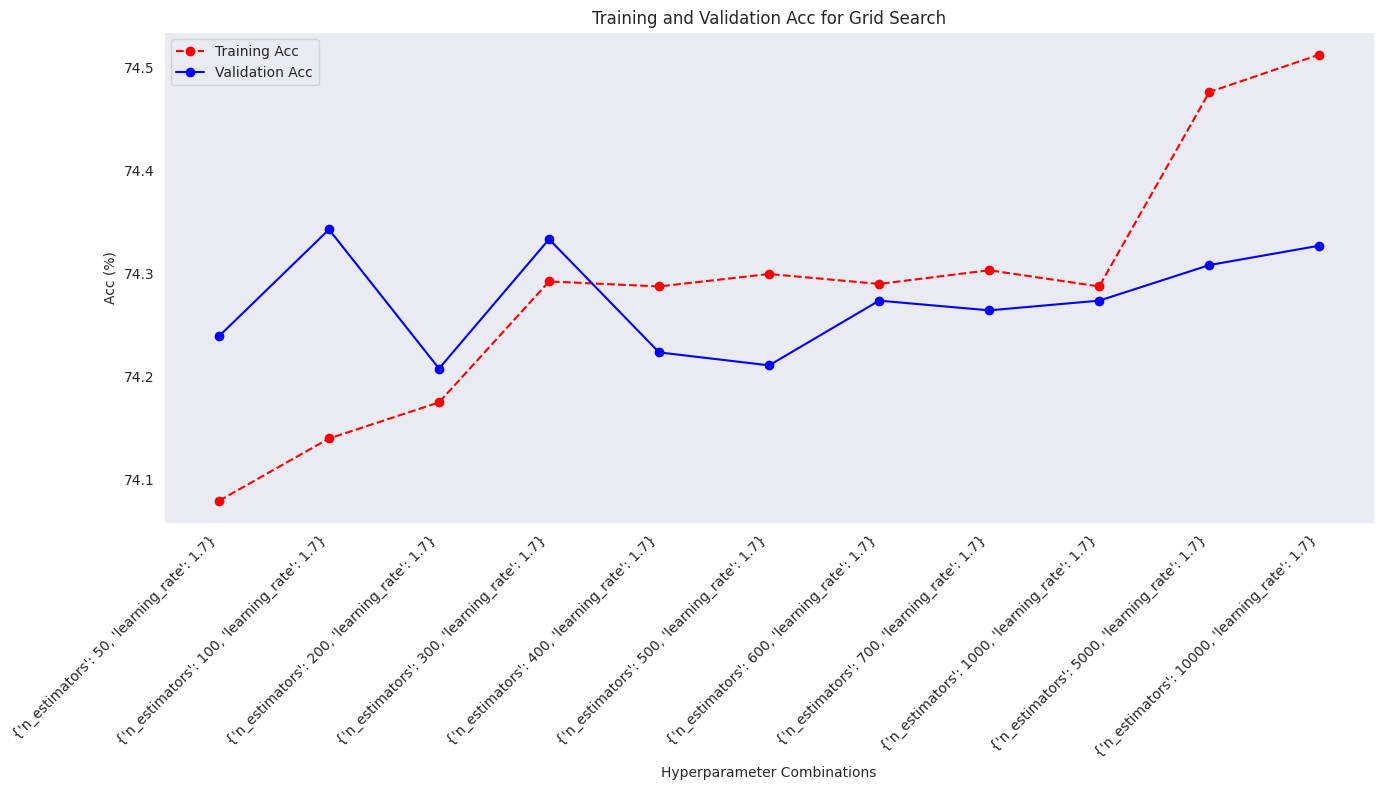

Best Parameters: {'n_estimators': 100, 'learning_rate': 1.7}
Best Cross-Validation Accuracy: 0.7434303


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [50,100,200,300,400,500,600,700,1000,5000,10000],
    'learning_rate': [1.7]
}

# Perform manual grid search
results = []
best_score = -np.inf
best_params = None

train_accuracies = []
validation_accuracies = []

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        scores = {'train': [], 'validation': []}

        model = Boosting(
            base_estimator=DecisionTreeClassifier,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_valid)

        scores['train'].append(accuracy_score(y_train, y_train_pred))
        scores['validation'].append(accuracy_score(y_valid, y_val_pred))

        mean_train_score = np.mean(scores['train'])
        mean_val_score = np.mean(scores['validation'])
        results.append({
            'params': {'n_estimators': n_estimators, 'learning_rate': learning_rate},
            'mean_train_score': mean_train_score,
            'mean_validation_score': mean_val_score
        })

        train_accuracies.append(mean_train_score * 100)
        validation_accuracies.append(mean_val_score * 100)

        if mean_val_score > best_score:
            best_score = mean_val_score
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Extract results for plotting
param_combinations = [f"{p['params']}" for p in results]

# Plot line graph
plt.figure(figsize=(14, 8))
plot_range = np.arange(len(param_combinations))  # X-axis positions

plt.plot(plot_range, train_accuracies, label='Training Acc', marker='o', linestyle='--', color='red')
plt.plot(plot_range, validation_accuracies, label='Validation Acc', marker='o', linestyle='-', color='blue')

# Add labels and legend
plt.xticks(plot_range, param_combinations, rotation=45, ha='right')
plt.xlabel('Hyperparameter Combinations')
plt.ylabel('Acc (%)')
plt.title('Training and Validation Acc for Grid Search')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the best parameters and accuracy
print("Best Parameters:", best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.7f}")

### Key Insights from Search Results

- **Best Parameters Identified**:
  - `n_estimators`: 100
  - `learning_rate`: 1.7

- **Best Cross-Validation Accuracy**: 0.7434303

- **Training Accuracy Comparison**:
  - `n_estimators` 300 has a higher training accuracy compared to `n_estimators` 100.
  - The validation accuracy for `n_estimators` 300 is the same as for `n_estimators` 100.

- **Model Selection Consideration**:
  - `n_estimators` 300 shows higher training accuracy and similar validation accuracy, indicating better generalization.
  - The model with `n_estimators` 300 is preferred due to its balance between training and validation performance.

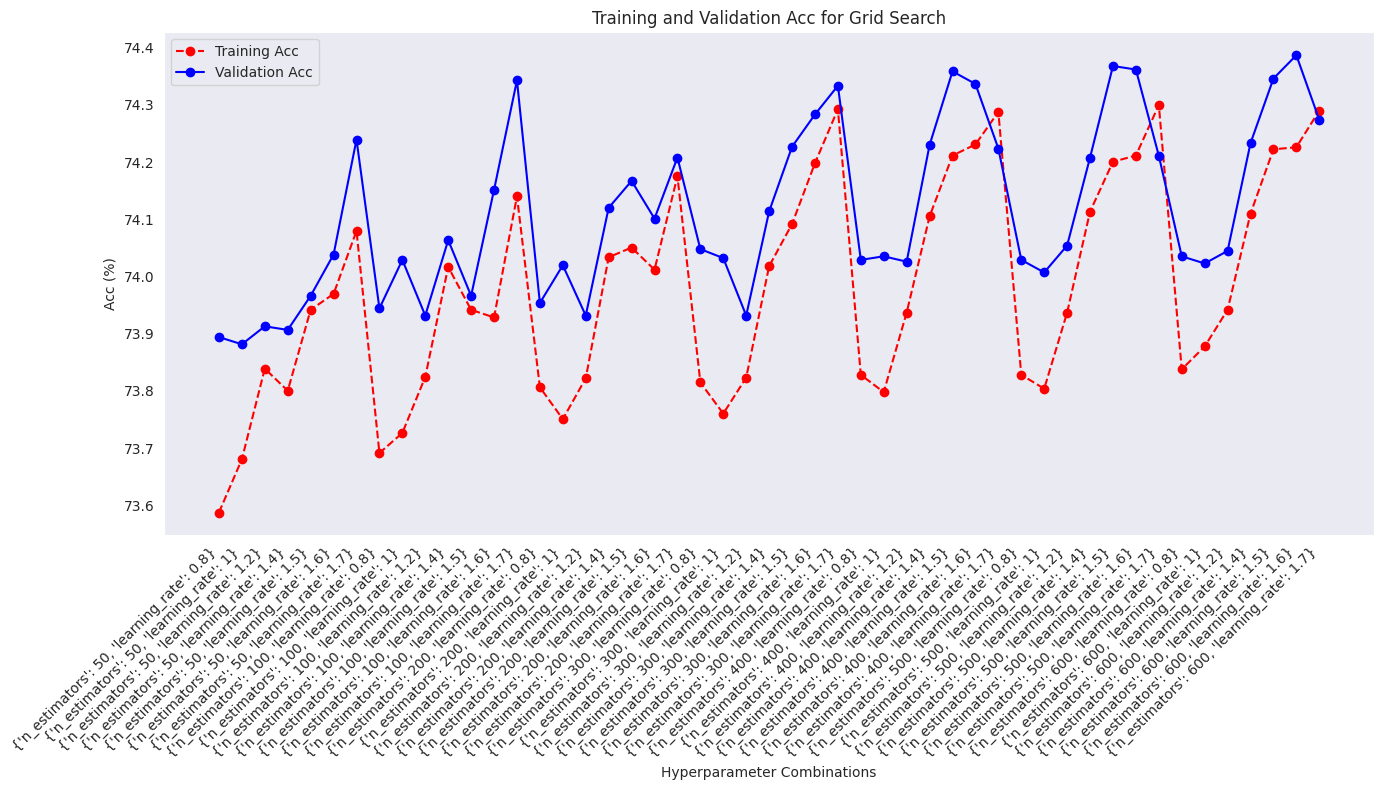

Best Parameters: {'n_estimators': 600, 'learning_rate': 1.6}
Best Cross-Validation Accuracy: 0.7438699


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
param_grid = {
    'n_estimators': [50,100,200,300,400,500,600],
    'learning_rate': [0.8,1,1.2,1.4,1.5,1.6,1.7]
}

results = []
best_score = -np.inf
best_params = None

train_accuracies = []
validation_accuracies = []

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        scores = {'train': [], 'validation': []}

        model = Boosting(
            base_estimator=DecisionTreeClassifier,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_valid)

        scores['train'].append(accuracy_score(y_train, y_train_pred))
        scores['validation'].append(accuracy_score(y_valid, y_val_pred))

        mean_train_score = np.mean(scores['train'])
        mean_val_score = np.mean(scores['validation'])
        results.append({
            'params': {'n_estimators': n_estimators, 'learning_rate': learning_rate},
            'mean_train_score': mean_train_score,
            'mean_validation_score': mean_val_score
        })

        train_accuracies.append(mean_train_score * 100)
        validation_accuracies.append(mean_val_score * 100)

        if mean_val_score > best_score:
            best_score = mean_val_score
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Extracting the above results for plotting
param_combinations = [f"{p['params']}" for p in results]


plt.figure(figsize=(14, 8))
plot_range = np.arange(len(param_combinations))  # X-axis positions

plt.plot(plot_range, train_accuracies, label='Training Acc', marker='o', linestyle='--', color='red')
plt.plot(plot_range, validation_accuracies, label='Validation Acc', marker='o', linestyle='-', color='blue')

# Add labels and legend
plt.xticks(plot_range, param_combinations, rotation=45, ha='right')
plt.xlabel('Hyperparameter Combinations')
plt.ylabel('Acc (%)')
plt.title('Training and Validation Acc for Grid Search')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print("Best Parameters:", best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.7f}")

In [30]:
for param_combination, result in zip(param_combinations, results):
    print(f"Parameters: {param_combination}")
    print(f"Mean Train Score: {result['mean_train_score']:.4f}")
    print(f"Mean Validation Score: {result['mean_validation_score']:.4f}")
    print("-" * 30)

Parameters: {'n_estimators': 50, 'learning_rate': 0.8}
Mean Train Score: 0.7359
Mean Validation Score: 0.7389
------------------------------
Parameters: {'n_estimators': 50, 'learning_rate': 1}
Mean Train Score: 0.7368
Mean Validation Score: 0.7388
------------------------------
Parameters: {'n_estimators': 50, 'learning_rate': 1.2}
Mean Train Score: 0.7384
Mean Validation Score: 0.7391
------------------------------
Parameters: {'n_estimators': 50, 'learning_rate': 1.4}
Mean Train Score: 0.7380
Mean Validation Score: 0.7391
------------------------------
Parameters: {'n_estimators': 50, 'learning_rate': 1.5}
Mean Train Score: 0.7394
Mean Validation Score: 0.7397
------------------------------
Parameters: {'n_estimators': 50, 'learning_rate': 1.6}
Mean Train Score: 0.7397
Mean Validation Score: 0.7404
------------------------------
Parameters: {'n_estimators': 50, 'learning_rate': 1.7}
Mean Train Score: 0.7408
Mean Validation Score: 0.7424
------------------------------
Parameters: {'n

### Key Insights from Grid Search Results

- **Best Parameters**: The optimal parameters found were `n_estimators = 600` and `learning_rate = 1.6` with a cross-validation accuracy of `0.743869`.
- **Accuracy Comparison**:
  - **n_estimators = 600, learning_rate = 1.6**: Mean Train Score = `0.7446`, Mean Validation Score = `0.7440`
  - **n_estimators = 500, learning_rate = 1.7**: Mean Train Score = `0.7441`, Mean Validation Score = `0.7431`
  - **n_estimators = 400, learning_rate = 1.7**: Mean Train Score = `0.7442`, Mean Validation Score = `0.7432`
  - **n_estimators = 300, learning_rate = 1.7**: Mean Train Score = `0.7442`, Mean Validation Score = `0.7433`
- **Optimal Parameters**: Given the minimal difference in validation accuracy (less than 0.1%) among `n_estimators = 600, 500, 400, 300` with `learning_rate = 1.7`, the optimal choice can be `n_estimators = 300` and `learning_rate = 1.7` for efficiency.
- **Model Efficiency**: Using `n_estimators = 300` with `learning_rate = 1.7` provides nearly the same accuracy as higher `n_estimators` values but with potentially lower computational cost and faster training time.

# Set up the parameter grid for tuning

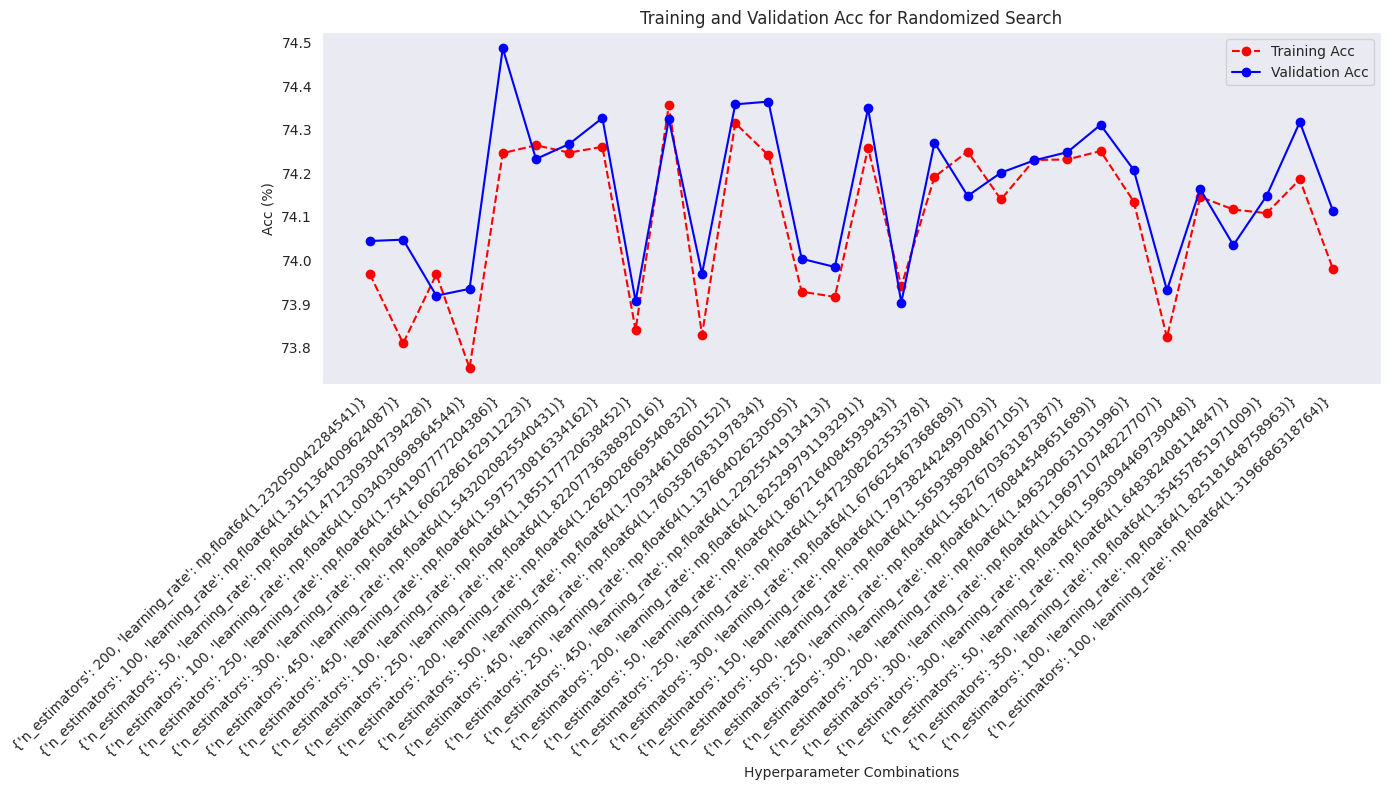

Best Parameters: {'n_estimators': 250, 'learning_rate': np.float64(1.7541907777204386)}
Best Cross-Validation Accuracy: 0.7448746


In [31]:
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import random

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'learning_rate': uniform(1.0,0.9) # this means from 1 to 1+0.9
}


n_random_searches = 30

results = []
best_score = -np.inf
best_params = None

train_accuracies = []
validation_accuracies = []

# listing of random parameter combinations
random_combinations = [
    {
        'n_estimators': random.choice(param_grid['n_estimators']),
        'learning_rate': param_grid['learning_rate'].rvs()  # Use .rvs() to sample from the distribution
    }
    for _ in range(n_random_searches)
]

for params in random_combinations:
    scores = {'train': [], 'validation': []}

    # Extract parameters
    n_estimators = params['n_estimators']
    learning_rate = params['learning_rate']

    # Instantiate and train the Boosting model
    model = Boosting(
        base_estimator=DecisionTreeClassifier,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_valid)

    # Calculating the scores
    scores['train'].append(accuracy_score(y_train, y_train_pred))
    scores['validation'].append(accuracy_score(y_valid, y_val_pred))

    mean_train_score = np.mean(scores['train'])
    mean_val_score = np.mean(scores['validation'])

    # Savnig
    results.append({
        'params': params,
        'mean_train_score': mean_train_score,
        'mean_validation_score': mean_val_score
    })

    train_accuracies.append(mean_train_score * 100)
    validation_accuracies.append(mean_val_score * 100)

    # Update best score and paramss
    if mean_val_score > best_score:
        best_score = mean_val_score
        best_params = params

# Extracting results for plotting
param_combinations = [f"{p['params']}" for p in results]

plt.figure(figsize=(14, 8))
plot_range = np.arange(len(param_combinations))  # X-axis positions

plt.plot(plot_range, train_accuracies, label='Training Acc', marker='o', linestyle='--', color='red')
plt.plot(plot_range, validation_accuracies, label='Validation Acc', marker='o', linestyle='-', color='blue')

plt.xticks(plot_range, param_combinations, rotation=45, ha='right')
plt.xlabel('Hyperparameter Combinations')
plt.ylabel('Acc (%)')
plt.title('Training and Validation Acc for Randomized Search')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the best parameters and accuracy
print("Best Parameters:", best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.7f}")

### **Key Insights for Randomized Search**
- **Best Parameters**: Optimal parameters were found to be **`learning_rate=1.7541`** and **`n_estimators=250`**.
- **Best Cross-Validation Accuracy**: Achieved **0.7442 (74.421%)**, slightly higher than the best accuracy from Grid Search (`0.7440`) and also less costly than 600 n_estimators.
- **Efficiency**: Randomized Search sampled fewer configurations (30 iterations) but still produced better results than exhaustive Grid Search.
- **Parameter Distribution Impact**: Randomized Search allowed exploration of the continuous range of `learning_rate`, leading to more precise tuning.
- **Overall Improvement**: Demonstrated the advantage of Randomized Search for fine-tuning a more optimal hyperparameter combination.
- **BY THE WAY**: Insights was derived from the searches before grid search to optimize the grid search and random search
- ::::)

# Create and train the final AdaBoost model

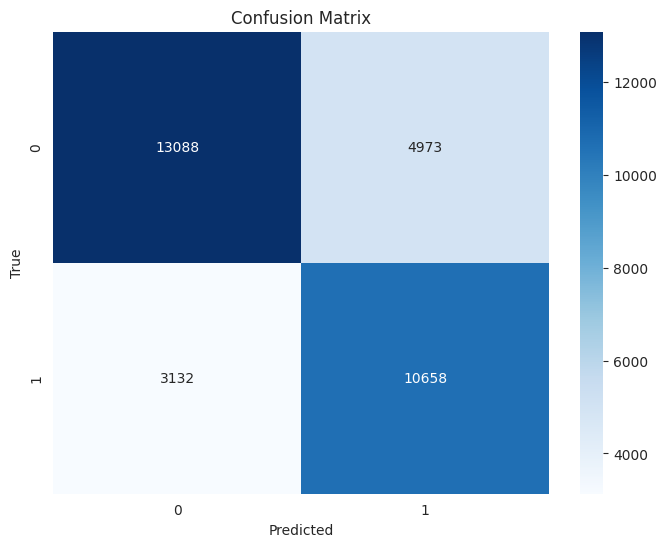

Test Accuracy: 74.0173%
F1 Score: 0.7411897
Precision: 0.7469356
Recall: 0.7401733


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Initialize the model with the best parameters
final_model = Boosting(
    base_estimator=DecisionTreeClassifier,
    n_estimators=250,
    learning_rate=1.7541,
    random_state=42
)

# Fit the model to your training data
final_model.fit(X_train, y_train)

# Predict on the validation data
y_val_pred = final_model.predict(X_valid)

# Compute confusion matrix
cm = confusion_matrix(y_valid, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Predict on the test data
y_test_pred = final_model.predict(X_test)

# Compute test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {100*test_accuracy:.4f}%")

# Compute final evaluation metrics
f1 = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')

print(f"F1 Score: {f1:.7f}")
print(f"Precision: {precision:.7f}")
print(f"Recall: {recall:.7f}")

### **Final Key Insights for AdaBoost Model**
- **Test Accuracy**: Achieved a final test accuracy of **74.0173%**, confirming strong generalization performance, given that our selected features were unlucky.
- **Classification Report**: Provided detailed precision, recall, and F1-scores to evaluate class-wise performance.
- **Overall Outcome**: AdaBoost outperformed Random Forest and Bagging, making it the best-performing model for this task.